In [64]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### データ読込

In [65]:
in_dir = '../data/two_years_each/train_val_consistent'

df_train_X = pd.read_excel(os.path.join(in_dir, 'train_X.xlsx'), header=0, index_col=0)
df_train_Y = pd.read_excel(os.path.join(in_dir, 'train_Y.xlsx'), header=0, index_col=0)

df_val_X = pd.read_excel(os.path.join(in_dir, 'val_X.xlsx'), header=0, index_col=0)
df_val_Y = pd.read_excel(os.path.join(in_dir, 'val_Y.xlsx'), header=0, index_col=0)

### 目的変数の分布

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

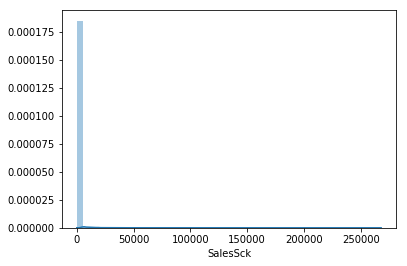

In [66]:
sns.distplot(df_train_Y['SalesSck'])
plt.plot()

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

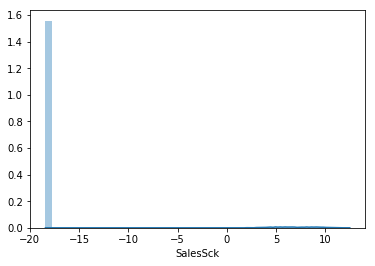

In [67]:
sns.distplot(np.log(df_train_Y['SalesSck'] + 0.00000001))
plt.plot()

In [68]:
def log(x):
    return np.log(x + 0.00000001)

#for c in ['Sales', 'Impressions', 'Clicks', 'Cost']:
for c in ['SalesSck']:
    df_train_Y['SalesSck_log'] = df_train_Y['SalesSck'].apply(log)
    df_val_Y['SalesSck_log'] = df_val_Y['SalesSck'].apply(log)

### データ構造転換

In [69]:
d_train_sales = xgb.DMatrix(df_train_X, label=df_train_Y['SalesSck_log'])
d_val_sales = xgb.DMatrix(df_val_X, label=df_val_Y['SalesSck_log'])

d_val = xgb.DMatrix(df_val_X)

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### パラメータのベイズ最適化

In [70]:
def score(params):
    print("Training with params: ")
    print(params)

    evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
    evals_result = {}

    model = xgb.train(params, 
              d_train_sales, 
              num_boost_round=100, 
              evals=evals,
              early_stopping_rounds=20,
              evals_result=evals_result)
    
    d_pred = np.exp(model.predict(d_val))
    loss = mean_squared_error(d_pred, df_val_Y['SalesRyutsu'].values)
    print(f'loss: {loss}')
    return {'loss': loss, 'status': STATUS_OK}

def optimize(random_state=71):
    
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'learning_rate': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(3, 10, dtype=int)),
        'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
        'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
        'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
        'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
        'lambda': hp.loguniform('lambda', np.log(1e-6), np.log(10.0)),
        'nthread': 4,
        'seed': random_state
    }
    best = fmin(score, space, 
                algo=tpe.suggest, 
                max_evals=250)
    return best
optimize()

Training with params:                                                                                                  
{'alpha': 1.0836396048404483e-06, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.2917911410528504, 'lambda': 0.035509847594567635, 'learning_rate': 0.42500000000000004, 'max_depth': 6, 'min_child_weight': 9.554192462460739, 'n_estimators': 408.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:11.2053	eval-rmse:11.3273                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.2184	eval-rmse:7.35442                                                                                

[2]	train-rmse:5.24484	eval-rmse:5.4031                                              

[21]	train-rmse:3.45813	eval-rmse:4.18096                                                                              

[22]	train-rmse:3.4127	eval-rmse:4.14745                                                                               

[23]	train-rmse:3.3709	eval-rmse:4.11707                                                                               

[24]	train-rmse:3.33901	eval-rmse:4.09648                                                                              

[25]	train-rmse:3.31018	eval-rmse:4.0784                                                                               

[26]	train-rmse:3.28891	eval-rmse:4.07005                                                                              

[27]	train-rmse:3.26934	eval-rmse:4.0571                                                                               

[28]	train-rmse:3.24965	eval-rmse:4.05197                                                                              

[29]	train-rmse:3.2328	eval-rmse

[11]	train-rmse:3.8197	eval-rmse:4.07528                                                                               

[12]	train-rmse:3.76857	eval-rmse:4.03261                                                                              

[13]	train-rmse:3.72875	eval-rmse:4.006                                                                                

[14]	train-rmse:3.70498	eval-rmse:3.98599                                                                              

[15]	train-rmse:3.68509	eval-rmse:3.96966                                                                              

[16]	train-rmse:3.67418	eval-rmse:3.96117                                                                              

[17]	train-rmse:3.65696	eval-rmse:3.96317                                                                              

[18]	train-rmse:3.6407	eval-rmse:3.95841                                                                               

[19]	train-rmse:3.63106	eval-rms

[22]	train-rmse:2.99503	eval-rmse:4.46361                                                                              

[23]	train-rmse:2.98061	eval-rmse:4.46602                                                                              

[24]	train-rmse:2.96109	eval-rmse:4.46639                                                                              

[25]	train-rmse:2.92941	eval-rmse:4.47338                                                                              

[26]	train-rmse:2.91361	eval-rmse:4.48595                                                                              

[27]	train-rmse:2.88784	eval-rmse:4.48343                                                                              

Stopping. Best iteration:                                                                                              
[7]	train-rmse:3.35351	eval-rmse:4.31411


loss: 11178824611.748505                                                                                       

[53]	train-rmse:3.54847	eval-rmse:3.93851                                                                              

[54]	train-rmse:3.54167	eval-rmse:3.93465                                                                              

[55]	train-rmse:3.53561	eval-rmse:3.93238                                                                              

[56]	train-rmse:3.53023	eval-rmse:3.92967                                                                              

[57]	train-rmse:3.52822	eval-rmse:3.92921                                                                              

[58]	train-rmse:3.52194	eval-rmse:3.92574                                                                              

[59]	train-rmse:3.51349	eval-rmse:3.92734                                                                              

[60]	train-rmse:3.50901	eval-rmse:3.92843                                                                              

[61]	train-rmse:3.50142	eval-rms

[33]	train-rmse:3.63895	eval-rmse:3.94926                                                                              

[34]	train-rmse:3.63331	eval-rmse:3.94674                                                                              

[35]	train-rmse:3.6275	eval-rmse:3.94606                                                                               

[36]	train-rmse:3.62077	eval-rmse:3.94674                                                                              

[37]	train-rmse:3.61533	eval-rmse:3.95236                                                                              

[38]	train-rmse:3.60587	eval-rmse:3.95404                                                                              

[39]	train-rmse:3.59675	eval-rmse:3.95195                                                                              

[40]	train-rmse:3.59099	eval-rmse:3.95018                                                                              

[41]	train-rmse:3.58512	eval-rms

[12]	train-rmse:3.86176	eval-rmse:4.38235                                                                              

[13]	train-rmse:3.74959	eval-rmse:4.28369                                                                              

[14]	train-rmse:3.66418	eval-rmse:4.20906                                                                              

[15]	train-rmse:3.60272	eval-rmse:4.16341                                                                              

[16]	train-rmse:3.55237	eval-rmse:4.12224                                                                              

[17]	train-rmse:3.50899	eval-rmse:4.09935                                                                              

[18]	train-rmse:3.47531	eval-rmse:4.0805                                                                               

[19]	train-rmse:3.44817	eval-rmse:4.06791                                                                              

[20]	train-rmse:3.43112	eval-rms

[21]	train-rmse:2.88356	eval-rmse:4.10369                                                                              

[22]	train-rmse:2.85552	eval-rmse:4.10354                                                                              

[23]	train-rmse:2.82858	eval-rmse:4.09066                                                                              

[24]	train-rmse:2.8078	eval-rmse:4.08333                                                                               

[25]	train-rmse:2.78234	eval-rmse:4.08769                                                                              

[26]	train-rmse:2.76418	eval-rmse:4.08428                                                                              

[27]	train-rmse:2.74646	eval-rmse:4.08231                                                                              

[28]	train-rmse:2.71917	eval-rmse:4.07803                                                                              

[29]	train-rmse:2.70328	eval-rms

[28]	train-rmse:3.36167	eval-rmse:3.98279                                                                              

[29]	train-rmse:3.35757	eval-rmse:3.98121                                                                              

[30]	train-rmse:3.3426	eval-rmse:3.9846                                                                                

[31]	train-rmse:3.33629	eval-rmse:3.9893                                                                               

[32]	train-rmse:3.3337	eval-rmse:3.9869                                                                                

[33]	train-rmse:3.33021	eval-rmse:3.98697                                                                              

[34]	train-rmse:3.32105	eval-rmse:3.99165                                                                              

[35]	train-rmse:3.31697	eval-rmse:3.99455                                                                              

[36]	train-rmse:3.31212	eval-rms

{'alpha': 0.11546925414739709, 'colsample_bytree': 0.75, 'gamma': 0.5302340536148787, 'lambda': 0.040399560491707176, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 0.1637245252389236, 'n_estimators': 675.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:16.8452	eval-rmse:16.9191                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:15.2607	eval-rmse:15.3379                                                                               

[2]	train-rmse:13.8452	eval-rmse:13.9273                                                                               

[3]	train-rmse:12.5787	eval-rmse:12.6693                                                                            

[63]	train-rmse:3.48995	eval-rmse:3.9316                                                                               

[64]	train-rmse:3.48705	eval-rmse:3.93146                                                                              

[65]	train-rmse:3.48341	eval-rmse:3.9327                                                                               

[66]	train-rmse:3.47702	eval-rmse:3.93734                                                                              

[67]	train-rmse:3.47063	eval-rmse:3.93861                                                                              

[68]	train-rmse:3.46566	eval-rmse:3.93639                                                                              

[69]	train-rmse:3.45968	eval-rmse:3.93567                                                                              

[70]	train-rmse:3.4571	eval-rmse:3.93456                                                                               

[71]	train-rmse:3.45314	eval-rms

[1]	train-rmse:11.0274	eval-rmse:11.0715                                                                               

[2]	train-rmse:8.70872	eval-rmse:8.72742                                                                               

[3]	train-rmse:7.07485	eval-rmse:7.06478                                                                               

[4]	train-rmse:5.95324	eval-rmse:5.92422                                                                               

[5]	train-rmse:5.21001	eval-rmse:5.15687                                                                               

[6]	train-rmse:4.73942	eval-rmse:4.6732                                                                                

[7]	train-rmse:4.44787	eval-rmse:4.37149                                                                               

[8]	train-rmse:4.27136	eval-rmse:4.19412                                                                               

[9]	train-rmse:4.16482	eval-rmse

[20]	train-rmse:4.15413	eval-rmse:4.52776                                                                              

[21]	train-rmse:4.04727	eval-rmse:4.43593                                                                              

[22]	train-rmse:3.95913	eval-rmse:4.35531                                                                              

[23]	train-rmse:3.88153	eval-rmse:4.29225                                                                              

[24]	train-rmse:3.81698	eval-rmse:4.23721                                                                              

[25]	train-rmse:3.76158	eval-rmse:4.19055                                                                              

[26]	train-rmse:3.71426	eval-rmse:4.14498                                                                              

[27]	train-rmse:3.67451	eval-rmse:4.10713                                                                              

[28]	train-rmse:3.64209	eval-rms

[8]	train-rmse:15.0251	eval-rmse:15.0994                                                                               

[9]	train-rmse:14.676	eval-rmse:14.7526                                                                                

[10]	train-rmse:14.3378	eval-rmse:14.4143                                                                              

[11]	train-rmse:14.0092	eval-rmse:14.0863                                                                              

[12]	train-rmse:13.689	eval-rmse:13.766                                                                                

[13]	train-rmse:13.3757	eval-rmse:13.4546                                                                              

[14]	train-rmse:13.071	eval-rmse:13.1511                                                                               

[15]	train-rmse:12.7781	eval-rmse:12.8567                                                                              

[16]	train-rmse:12.4896	eval-rms

[75]	train-rmse:4.7235	eval-rmse:4.82141                                                                               

[76]	train-rmse:4.68464	eval-rmse:4.78192                                                                              

[77]	train-rmse:4.64762	eval-rmse:4.74498                                                                              

[78]	train-rmse:4.61181	eval-rmse:4.70912                                                                              

[79]	train-rmse:4.57713	eval-rmse:4.67515                                                                              

[80]	train-rmse:4.54388	eval-rmse:4.64246                                                                              

[81]	train-rmse:4.51203	eval-rmse:4.61179                                                                              

[82]	train-rmse:4.48219	eval-rmse:4.58153                                                                              

[83]	train-rmse:4.4535	eval-rmse

[36]	train-rmse:3.95791	eval-rmse:4.09764                                                                              

[37]	train-rmse:3.93415	eval-rmse:4.07465                                                                              

[38]	train-rmse:3.91443	eval-rmse:4.05694                                                                              

[39]	train-rmse:3.89397	eval-rmse:4.03502                                                                              

[40]	train-rmse:3.87873	eval-rmse:4.02191                                                                              

[41]	train-rmse:3.86496	eval-rmse:4.00797                                                                              

[42]	train-rmse:3.85283	eval-rmse:3.99566                                                                              

[43]	train-rmse:3.84001	eval-rmse:3.98582                                                                              

[44]	train-rmse:3.82925	eval-rms

{'alpha': 7.575125726217051e-05, 'colsample_bytree': 0.8500000000000001, 'gamma': 1.1140603172172582e-05, 'lambda': 1.025021965270839, 'learning_rate': 0.125, 'max_depth': 6, 'min_child_weight': 0.18277075963560765, 'n_estimators': 831.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:16.4074	eval-rmse:16.4896                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:14.4846	eval-rmse:14.5829                                                                               

[2]	train-rmse:12.8168	eval-rmse:12.927                                                                                

[3]	train-rmse:11.3773	eval-rmse:11.4981                                                        

[63]	train-rmse:3.42496	eval-rmse:3.97317                                                                              

[64]	train-rmse:3.4206	eval-rmse:3.97602                                                                               

[65]	train-rmse:3.41625	eval-rmse:3.96918                                                                              

[66]	train-rmse:3.40821	eval-rmse:3.9716                                                                               

[67]	train-rmse:3.4046	eval-rmse:3.97065                                                                               

[68]	train-rmse:3.40113	eval-rmse:3.96995                                                                              

[69]	train-rmse:3.39679	eval-rmse:3.97077                                                                              

[70]	train-rmse:3.39351	eval-rmse:3.97327                                                                              

[71]	train-rmse:3.38878	eval-rms

[40]	train-rmse:7.38092	eval-rmse:7.68771                                                                              

[41]	train-rmse:7.23686	eval-rmse:7.55055                                                                              

[42]	train-rmse:7.09566	eval-rmse:7.41945                                                                              

[43]	train-rmse:6.95994	eval-rmse:7.29068                                                                              

[44]	train-rmse:6.8271	eval-rmse:7.16549                                                                               

[45]	train-rmse:6.69859	eval-rmse:7.04537                                                                              

[46]	train-rmse:6.57532	eval-rmse:6.92921                                                                              

[47]	train-rmse:6.45449	eval-rmse:6.81783                                                                              

[48]	train-rmse:6.3369	eval-rmse

[1]	train-rmse:13.0096	eval-rmse:13.1098                                                                               

[2]	train-rmse:10.9667	eval-rmse:11.0787                                                                               

[3]	train-rmse:9.31686	eval-rmse:9.45141                                                                               

[4]	train-rmse:7.99727	eval-rmse:8.14641                                                                               

[5]	train-rmse:6.95192	eval-rmse:7.11556                                                                               

[6]	train-rmse:6.13605	eval-rmse:6.31555                                                                               

[7]	train-rmse:5.50483	eval-rmse:5.71063                                                                               

[8]	train-rmse:5.02711	eval-rmse:5.24205                                                                               

[9]	train-rmse:4.66801	eval-rmse

[6]	train-rmse:13.3324	eval-rmse:13.395                                                                                

[7]	train-rmse:12.7293	eval-rmse:12.7918                                                                               

[8]	train-rmse:12.1605	eval-rmse:12.2197                                                                               

[9]	train-rmse:11.6215	eval-rmse:11.6811                                                                               

[10]	train-rmse:11.1126	eval-rmse:11.1686                                                                              

[11]	train-rmse:10.6317	eval-rmse:10.6888                                                                              

[12]	train-rmse:10.1792	eval-rmse:10.2329                                                                              

[13]	train-rmse:9.754	eval-rmse:9.80536                                                                                

[14]	train-rmse:9.35096	eval-rms

[73]	train-rmse:3.9397	eval-rmse:3.93747                                                                               

[74]	train-rmse:3.93586	eval-rmse:3.9343                                                                               

[75]	train-rmse:3.93316	eval-rmse:3.93154                                                                              

[76]	train-rmse:3.93048	eval-rmse:3.92849                                                                              

[77]	train-rmse:3.92862	eval-rmse:3.92561                                                                              

[78]	train-rmse:3.9255	eval-rmse:3.92391                                                                               

[79]	train-rmse:3.92225	eval-rmse:3.92257                                                                              

[80]	train-rmse:3.92015	eval-rmse:3.91813                                                                              

[81]	train-rmse:3.9181	eval-rmse

[34]	train-rmse:3.14089	eval-rmse:4.06939                                                                              

[35]	train-rmse:3.13575	eval-rmse:4.07032                                                                              

[36]	train-rmse:3.1298	eval-rmse:4.07188                                                                               

[37]	train-rmse:3.11632	eval-rmse:4.07435                                                                              

[38]	train-rmse:3.10929	eval-rmse:4.07273                                                                              

[39]	train-rmse:3.10554	eval-rmse:4.07623                                                                              

[40]	train-rmse:3.09982	eval-rmse:4.07921                                                                              

Stopping. Best iteration:                                                                                              
[20]	train-rmse:3.34102	eval-rmse

[53]	train-rmse:3.1716	eval-rmse:4.00823                                                                               

[54]	train-rmse:3.16468	eval-rmse:4.00588                                                                              

[55]	train-rmse:3.15714	eval-rmse:4.00434                                                                              

[56]	train-rmse:3.1506	eval-rmse:4.00162                                                                               

[57]	train-rmse:3.14584	eval-rmse:4.00234                                                                              

[58]	train-rmse:3.13905	eval-rmse:4.00359                                                                              

[59]	train-rmse:3.13241	eval-rmse:4.0035                                                                               

[60]	train-rmse:3.1249	eval-rmse:4.00108                                                                               

[61]	train-rmse:3.11695	eval-rms

[29]	train-rmse:3.27441	eval-rmse:4.21538                                                                              

[30]	train-rmse:3.26055	eval-rmse:4.21752                                                                              

[31]	train-rmse:3.2502	eval-rmse:4.22196                                                                               

Stopping. Best iteration:                                                                                              
[11]	train-rmse:3.57976	eval-rmse:4.12945


loss: 121011979.79998593                                                                                               
Training with params:                                                                                                  
{'alpha': 1.7558174691295416e-05, 'colsample_bytree': 0.75, 'gamma': 0.0013291772079731096, 'lambda': 0.016377359333061902, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'min_child_weight': 4.824011341542593, 'n_estimators': 

[57]	train-rmse:3.99006	eval-rmse:3.88877                                                                              

[58]	train-rmse:3.98789	eval-rmse:3.88712                                                                              

[59]	train-rmse:3.98633	eval-rmse:3.88467                                                                              

[60]	train-rmse:3.9841	eval-rmse:3.8821                                                                                

[61]	train-rmse:3.98244	eval-rmse:3.88156                                                                              

[62]	train-rmse:3.98136	eval-rmse:3.88138                                                                              

[63]	train-rmse:3.97947	eval-rmse:3.87972                                                                              

[64]	train-rmse:3.97837	eval-rmse:3.87965                                                                              

[65]	train-rmse:3.97743	eval-rms

[18]	train-rmse:3.93614	eval-rmse:3.95869                                                                              

[19]	train-rmse:3.929	eval-rmse:3.95363                                                                                

[20]	train-rmse:3.91981	eval-rmse:3.95451                                                                              

[21]	train-rmse:3.91301	eval-rmse:3.95395                                                                              

[22]	train-rmse:3.90535	eval-rmse:3.95064                                                                              

[23]	train-rmse:3.90221	eval-rmse:3.94886                                                                              

[24]	train-rmse:3.89922	eval-rmse:3.94604                                                                              

[25]	train-rmse:3.89515	eval-rmse:3.94383                                                                              

[26]	train-rmse:3.89213	eval-rms

[30]	train-rmse:9.1755	eval-rmse:9.33364                                                                               

[31]	train-rmse:8.9875	eval-rmse:9.14834                                                                               

[32]	train-rmse:8.8036	eval-rmse:8.96638                                                                               

[33]	train-rmse:8.62427	eval-rmse:8.7897                                                                               

[34]	train-rmse:8.45153	eval-rmse:8.61857                                                                              

[35]	train-rmse:8.2832	eval-rmse:8.45228                                                                               

[36]	train-rmse:8.12	eval-rmse:8.29154                                                                                 

[37]	train-rmse:7.96189	eval-rmse:8.1349                                                                               

[38]	train-rmse:7.80725	eval-rms

[97]	train-rmse:3.93523	eval-rmse:4.30102                                                                              

[98]	train-rmse:3.91833	eval-rmse:4.2859                                                                               

[99]	train-rmse:3.90103	eval-rmse:4.27115                                                                              

loss: 103732427.65365286                                                                                               
Training with params:                                                                                                  
{'alpha': 0.00022275613535235897, 'colsample_bytree': 0.75, 'gamma': 0.0007601840202822643, 'lambda': 0.0025855973236895047, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 0.2736502475607599, 'n_estimators': 597.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:16.8393	eval-rmse:16.9313                                                                        

[58]	train-rmse:3.05962	eval-rmse:4.01354                                                                              

[59]	train-rmse:3.04994	eval-rmse:4.01392                                                                              

[60]	train-rmse:3.04147	eval-rmse:4.01631                                                                              

[61]	train-rmse:3.02905	eval-rmse:4.01778                                                                              

[62]	train-rmse:3.0214	eval-rmse:4.01323                                                                               

[63]	train-rmse:3.01593	eval-rmse:4.0134                                                                               

[64]	train-rmse:3.01213	eval-rmse:4.0159                                                                               

[65]	train-rmse:3.00755	eval-rmse:4.01795                                                                              

Stopping. Best iteration:       

[9]	train-rmse:3.41359	eval-rmse:4.26678                                                                               

[10]	train-rmse:3.40164	eval-rmse:4.26121                                                                              

[11]	train-rmse:3.35076	eval-rmse:4.29882                                                                              

[12]	train-rmse:3.33177	eval-rmse:4.31353                                                                              

[13]	train-rmse:3.31127	eval-rmse:4.31241                                                                              

[14]	train-rmse:3.29517	eval-rmse:4.31644                                                                              

[15]	train-rmse:3.28117	eval-rmse:4.33158                                                                              

[16]	train-rmse:3.27231	eval-rmse:4.33996                                                                              

[17]	train-rmse:3.24952	eval-rms

[38]	train-rmse:4.00718	eval-rmse:3.90303                                                                              

[39]	train-rmse:4.00331	eval-rmse:3.9                                                                                  

[40]	train-rmse:3.99872	eval-rmse:3.90074                                                                              

[41]	train-rmse:3.99632	eval-rmse:3.89832                                                                              

[42]	train-rmse:3.99307	eval-rmse:3.89943                                                                              

[43]	train-rmse:3.99022	eval-rmse:3.8992                                                                               

[44]	train-rmse:3.98874	eval-rmse:3.89644                                                                              

[45]	train-rmse:3.98717	eval-rmse:3.89425                                                                              

[46]	train-rmse:3.98476	eval-rms

[14]	train-rmse:9.15424	eval-rmse:9.44877                                                                              

[15]	train-rmse:8.75931	eval-rmse:9.07136                                                                              

[16]	train-rmse:8.38467	eval-rmse:8.71332                                                                              

[17]	train-rmse:8.03147	eval-rmse:8.37791                                                                              

[18]	train-rmse:7.69828	eval-rmse:8.06335                                                                              

[19]	train-rmse:7.38267	eval-rmse:7.76883                                                                              

[20]	train-rmse:7.08477	eval-rmse:7.49384                                                                              

[21]	train-rmse:6.80692	eval-rmse:7.23713                                                                              

[22]	train-rmse:6.54438	eval-rms

[81]	train-rmse:2.78514	eval-rmse:4.01103                                                                              

[82]	train-rmse:2.78005	eval-rmse:4.01043                                                                              

[83]	train-rmse:2.77031	eval-rmse:4.01429                                                                              

[84]	train-rmse:2.7644	eval-rmse:4.01438                                                                               

[85]	train-rmse:2.75999	eval-rmse:4.01296                                                                              

[86]	train-rmse:2.75256	eval-rmse:4.01365                                                                              

[87]	train-rmse:2.7495	eval-rmse:4.01226                                                                               

[88]	train-rmse:2.74767	eval-rmse:4.01044                                                                              

[89]	train-rmse:2.74082	eval-rms

{'alpha': 0.0024077425748329348, 'colsample_bytree': 0.65, 'gamma': 5.172545702001203e-06, 'lambda': 1.7796767616461322e-06, 'learning_rate': 0.5, 'max_depth': 8, 'min_child_weight': 0.31848630945295875, 'n_estimators': 396.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:9.89368	eval-rmse:10.1242                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:5.92404	eval-rmse:6.28242                                                                               

[2]	train-rmse:4.3184	eval-rmse:4.91883                                                                                

[3]	train-rmse:3.77108	eval-rmse:4.44665                                                                    

[29]	train-rmse:3.43827	eval-rmse:4.04302                                                                              

[30]	train-rmse:3.42256	eval-rmse:4.04852                                                                              

[31]	train-rmse:3.41458	eval-rmse:4.05042                                                                              

[32]	train-rmse:3.40153	eval-rmse:4.05785                                                                              

[33]	train-rmse:3.39356	eval-rmse:4.05034                                                                              

[34]	train-rmse:3.38941	eval-rmse:4.05073                                                                              

[35]	train-rmse:3.37844	eval-rmse:4.05215                                                                              

[36]	train-rmse:3.37215	eval-rmse:4.05201                                                                              

[37]	train-rmse:3.36836	eval-rms

[27]	train-rmse:2.65734	eval-rmse:4.49348                                                                              

[28]	train-rmse:2.6332	eval-rmse:4.48853                                                                               

Stopping. Best iteration:                                                                                              
[8]	train-rmse:3.19689	eval-rmse:4.24767


loss: 243794201374697.38                                                                                               
Training with params:                                                                                                  
{'alpha': 0.00013842034219112197, 'colsample_bytree': 0.7000000000000001, 'gamma': 5.613267361963266e-05, 'lambda': 0.4540613423000295, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 0.1039559700490898, 'n_estimators': 904.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:16.8369	eval-rmse:16.9288                                 

[58]	train-rmse:2.99648	eval-rmse:3.97497                                                                              

[59]	train-rmse:2.99164	eval-rmse:3.9752                                                                               

[60]	train-rmse:2.98535	eval-rmse:3.97229                                                                              

[61]	train-rmse:2.97468	eval-rmse:3.97194                                                                              

[62]	train-rmse:2.96982	eval-rmse:3.97323                                                                              

[63]	train-rmse:2.96498	eval-rmse:3.97672                                                                              

[64]	train-rmse:2.95956	eval-rmse:3.97978                                                                              

[65]	train-rmse:2.95271	eval-rmse:3.98434                                                                              

[66]	train-rmse:2.94723	eval-rms

[36]	train-rmse:3.69231	eval-rmse:3.99834                                                                              

[37]	train-rmse:3.68097	eval-rmse:4.00113                                                                              

[38]	train-rmse:3.67469	eval-rmse:3.99931                                                                              

[39]	train-rmse:3.67355	eval-rmse:4.00237                                                                              

[40]	train-rmse:3.66559	eval-rmse:4.00684                                                                              

[41]	train-rmse:3.6574	eval-rmse:4.00819                                                                               

[42]	train-rmse:3.64858	eval-rmse:4.01908                                                                              

[43]	train-rmse:3.6417	eval-rmse:4.01701                                                                               

[44]	train-rmse:3.63749	eval-rms

[7]	train-rmse:3.75252	eval-rmse:4.31933                                                                               

[8]	train-rmse:3.64138	eval-rmse:4.22604                                                                               

[9]	train-rmse:3.58	eval-rmse:4.18977                                                                                  

[10]	train-rmse:3.53921	eval-rmse:4.16051                                                                              

[11]	train-rmse:3.50068	eval-rmse:4.15991                                                                              

[12]	train-rmse:3.47083	eval-rmse:4.15525                                                                              

[13]	train-rmse:3.44059	eval-rmse:4.13396                                                                              

[14]	train-rmse:3.43029	eval-rmse:4.13484                                                                              

[15]	train-rmse:3.40096	eval-rms

{'alpha': 5.68814293530907e-08, 'colsample_bytree': 0.9500000000000001, 'gamma': 3.0183166477551815e-08, 'lambda': 0.006439963577473584, 'learning_rate': 0.35000000000000003, 'max_depth': 7, 'min_child_weight': 1.3851379974983882, 'n_estimators': 372.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:12.4668	eval-rmse:12.5817                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:8.6167	eval-rmse:8.81363                                                                                

[2]	train-rmse:6.30019	eval-rmse:6.54245                                                                               

[3]	train-rmse:4.98597	eval-rmse:5.30933                                         

[24]	train-rmse:3.33923	eval-rmse:4.08744                                                                              

[25]	train-rmse:3.32868	eval-rmse:4.10474                                                                              

[26]	train-rmse:3.31763	eval-rmse:4.10257                                                                              

[27]	train-rmse:3.29823	eval-rmse:4.12126                                                                              

[28]	train-rmse:3.29053	eval-rmse:4.1379                                                                               

[29]	train-rmse:3.26918	eval-rmse:4.14114                                                                              

[30]	train-rmse:3.25273	eval-rmse:4.1477                                                                               

[31]	train-rmse:3.23822	eval-rmse:4.15154                                                                              

[32]	train-rmse:3.22352	eval-rms

[3]	train-rmse:4.23824	eval-rmse:4.85066                                                                               

[4]	train-rmse:3.7116	eval-rmse:4.44712                                                                                

[5]	train-rmse:3.47488	eval-rmse:4.29944                                                                               

[6]	train-rmse:3.37569	eval-rmse:4.2066                                                                                

[7]	train-rmse:3.29576	eval-rmse:4.18808                                                                               

[8]	train-rmse:3.25927	eval-rmse:4.18192                                                                               

[9]	train-rmse:3.23819	eval-rmse:4.1818                                                                                

[10]	train-rmse:3.22409	eval-rmse:4.18231                                                                              

[11]	train-rmse:3.17805	eval-rms

[30]	train-rmse:3.9442	eval-rmse:3.92656                                                                               

[31]	train-rmse:3.94046	eval-rmse:3.92823                                                                              

[32]	train-rmse:3.93673	eval-rmse:3.92218                                                                              

[33]	train-rmse:3.93525	eval-rmse:3.9225                                                                               

[34]	train-rmse:3.93083	eval-rmse:3.93425                                                                              

[35]	train-rmse:3.92818	eval-rmse:3.93998                                                                              

[36]	train-rmse:3.92558	eval-rmse:3.94184                                                                              

[37]	train-rmse:3.92448	eval-rmse:3.94316                                                                              

[38]	train-rmse:3.92196	eval-rms

[41]	train-rmse:3.31479	eval-rmse:4.12852                                                                              

[42]	train-rmse:3.30126	eval-rmse:4.13991                                                                              

[43]	train-rmse:3.2917	eval-rmse:4.14349                                                                               

Stopping. Best iteration:                                                                                              
[23]	train-rmse:3.48623	eval-rmse:4.06958


loss: 103825547.65079683                                                                                               
Training with params:                                                                                                  
{'alpha': 2.9554846321882726e-07, 'colsample_bytree': 0.8, 'gamma': 2.885233232495417e-07, 'lambda': 6.028859306926972e-06, 'learning_rate': 0.25, 'max_depth': 5, 'min_child_weight': 0.1378202566476716, 'n_estimators': 428.0, 'nthrea

[12]	train-rmse:4.09627	eval-rmse:4.07998                                                                              

[13]	train-rmse:4.04536	eval-rmse:4.02859                                                                              

[14]	train-rmse:4.01216	eval-rmse:3.99661                                                                              

[15]	train-rmse:3.98642	eval-rmse:3.97609                                                                              

[16]	train-rmse:3.97075	eval-rmse:3.95973                                                                              

[17]	train-rmse:3.95697	eval-rmse:3.94907                                                                              

[18]	train-rmse:3.94561	eval-rmse:3.9356                                                                               

[19]	train-rmse:3.93501	eval-rmse:3.9319                                                                               

[20]	train-rmse:3.92764	eval-rms

[23]	train-rmse:3.67296	eval-rmse:3.99596                                                                              

[24]	train-rmse:3.66109	eval-rmse:3.98597                                                                              

[25]	train-rmse:3.65248	eval-rmse:3.97917                                                                              

[26]	train-rmse:3.64357	eval-rmse:3.97763                                                                              

[27]	train-rmse:3.63356	eval-rmse:3.97088                                                                              

[28]	train-rmse:3.62294	eval-rmse:3.97438                                                                              

[29]	train-rmse:3.61407	eval-rmse:3.97209                                                                              

[30]	train-rmse:3.60365	eval-rmse:3.97294                                                                              

[31]	train-rmse:3.59615	eval-rms

Stopping. Best iteration:                                                                                              
[6]	train-rmse:3.62089	eval-rmse:4.14213


loss: 104740015.54120137                                                                                               
Training with params:                                                                                                  
{'alpha': 3.6144017131497193e-06, 'colsample_bytree': 0.65, 'gamma': 0.17422738787619627, 'lambda': 0.6824242626903604, 'learning_rate': 0.225, 'max_depth': 7, 'min_child_weight': 0.11956368966009569, 'n_estimators': 863.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:14.6447	eval-rmse:14.7649                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                             

[10]	train-rmse:3.44624	eval-rmse:4.19982                                                                              

[11]	train-rmse:3.33323	eval-rmse:4.136                                                                                

[12]	train-rmse:3.25011	eval-rmse:4.09835                                                                              

[13]	train-rmse:3.18438	eval-rmse:4.09014                                                                              

[14]	train-rmse:3.16113	eval-rmse:4.07303                                                                              

[15]	train-rmse:3.12915	eval-rmse:4.04241                                                                              

[16]	train-rmse:3.10913	eval-rmse:4.02922                                                                              

[17]	train-rmse:3.07735	eval-rmse:4.03181                                                                              

[18]	train-rmse:3.04656	eval-rms

[33]	train-rmse:3.61739	eval-rmse:4.1548                                                                               

[34]	train-rmse:3.61281	eval-rmse:4.1574                                                                               

Stopping. Best iteration:                                                                                              
[14]	train-rmse:3.81073	eval-rmse:4.0658


loss: 103732680.74577242                                                                                               
Training with params:                                                                                                  
{'alpha': 1.989039653913996e-05, 'colsample_bytree': 0.65, 'gamma': 0.3283639900706568, 'lambda': 0.0016684869317853887, 'learning_rate': 0.35000000000000003, 'max_depth': 3, 'min_child_weight': 0.845376286226549, 'n_estimators': 289.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:12.5182	eval-rmse:12.5583                   

[17]	train-rmse:3.38555	eval-rmse:4.02172                                                                              

[18]	train-rmse:3.36413	eval-rmse:4.02078                                                                              

[19]	train-rmse:3.3538	eval-rmse:4.03405                                                                               

[20]	train-rmse:3.3408	eval-rmse:4.03963                                                                               

[21]	train-rmse:3.32215	eval-rmse:4.04546                                                                              

[22]	train-rmse:3.31583	eval-rmse:4.04598                                                                              

[23]	train-rmse:3.29882	eval-rmse:4.04684                                                                              

[24]	train-rmse:3.29013	eval-rmse:4.04702                                                                              

[25]	train-rmse:3.28403	eval-rms

{'alpha': 0.0013391558449689929, 'colsample_bytree': 0.75, 'gamma': 0.00039731927305898865, 'lambda': 0.005263811474298736, 'learning_rate': 0.4, 'max_depth': 4, 'min_child_weight': 1.5933458792490982, 'n_estimators': 227.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:11.6518	eval-rmse:11.7131                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.71605	eval-rmse:7.76669                                                                               

[2]	train-rmse:5.64811	eval-rmse:5.69282                                                                               

[3]	train-rmse:4.67141	eval-rmse:4.68698                                                                               

[4]

[24]	train-rmse:3.43536	eval-rmse:4.04605                                                                              

[25]	train-rmse:3.42546	eval-rmse:4.04959                                                                              

[26]	train-rmse:3.41244	eval-rmse:4.04564                                                                              

[27]	train-rmse:3.40297	eval-rmse:4.03974                                                                              

[28]	train-rmse:3.38801	eval-rmse:4.03201                                                                              

[29]	train-rmse:3.38005	eval-rmse:4.0311                                                                               

[30]	train-rmse:3.36829	eval-rmse:4.02681                                                                              

[31]	train-rmse:3.36085	eval-rmse:4.0284                                                                               

[32]	train-rmse:3.35114	eval-rms

[29]	train-rmse:3.38994	eval-rmse:4.05376                                                                              

[30]	train-rmse:3.3704	eval-rmse:4.06021                                                                               

[31]	train-rmse:3.35847	eval-rmse:4.05522                                                                              

[32]	train-rmse:3.34732	eval-rmse:4.05377                                                                              

[33]	train-rmse:3.33765	eval-rmse:4.05568                                                                              

[34]	train-rmse:3.33016	eval-rmse:4.05494                                                                              

[35]	train-rmse:3.32634	eval-rmse:4.06071                                                                              

[36]	train-rmse:3.31704	eval-rmse:4.06449                                                                              

[37]	train-rmse:3.30926	eval-rms

[42]	train-rmse:3.96842	eval-rmse:3.89894                                                                              

[43]	train-rmse:3.96651	eval-rmse:3.89701                                                                              

[44]	train-rmse:3.96371	eval-rmse:3.89363                                                                              

[45]	train-rmse:3.96157	eval-rmse:3.89274                                                                              

[46]	train-rmse:3.95951	eval-rmse:3.89027                                                                              

[47]	train-rmse:3.95764	eval-rmse:3.88934                                                                              

[48]	train-rmse:3.95603	eval-rmse:3.88828                                                                              

[49]	train-rmse:3.9543	eval-rmse:3.88852                                                                               

[50]	train-rmse:3.95302	eval-rms

[23]	train-rmse:3.56021	eval-rmse:4.10307                                                                              

[24]	train-rmse:3.54642	eval-rmse:4.0996                                                                               

[25]	train-rmse:3.53768	eval-rmse:4.09974                                                                              

[26]	train-rmse:3.52368	eval-rmse:4.09085                                                                              

[27]	train-rmse:3.51162	eval-rmse:4.08648                                                                              

[28]	train-rmse:3.48904	eval-rmse:4.10619                                                                              

[29]	train-rmse:3.48339	eval-rmse:4.11348                                                                              

[30]	train-rmse:3.46645	eval-rmse:4.12277                                                                              

[31]	train-rmse:3.4546	eval-rmse

[48]	train-rmse:3.65425	eval-rmse:3.98316                                                                              

[49]	train-rmse:3.64638	eval-rmse:3.97686                                                                              

[50]	train-rmse:3.6425	eval-rmse:3.97858                                                                               

[51]	train-rmse:3.63706	eval-rmse:3.97843                                                                              

[52]	train-rmse:3.6272	eval-rmse:3.98681                                                                               

[53]	train-rmse:3.6217	eval-rmse:3.98642                                                                               

[54]	train-rmse:3.61363	eval-rmse:3.98853                                                                              

[55]	train-rmse:3.60966	eval-rmse:3.98675                                                                              

[56]	train-rmse:3.60516	eval-rms

[49]	train-rmse:3.74785	eval-rmse:4.25082                                                                              

[50]	train-rmse:3.71654	eval-rmse:4.22512                                                                              

[51]	train-rmse:3.68596	eval-rmse:4.20419                                                                              

[52]	train-rmse:3.65709	eval-rmse:4.18282                                                                              

[53]	train-rmse:3.63187	eval-rmse:4.16194                                                                              

[54]	train-rmse:3.60828	eval-rmse:4.14433                                                                              

[55]	train-rmse:3.58814	eval-rmse:4.12829                                                                              

[56]	train-rmse:3.56737	eval-rmse:4.11332                                                                              

[57]	train-rmse:3.54682	eval-rms

[10]	train-rmse:5.03701	eval-rmse:5.0498                                                                               

[11]	train-rmse:4.76685	eval-rmse:4.77431                                                                              

[12]	train-rmse:4.56131	eval-rmse:4.5647                                                                               

[13]	train-rmse:4.40595	eval-rmse:4.40416                                                                              

[14]	train-rmse:4.28924	eval-rmse:4.28253                                                                              

[15]	train-rmse:4.19961	eval-rmse:4.19011                                                                              

[16]	train-rmse:4.13132	eval-rmse:4.12151                                                                              

[17]	train-rmse:4.08053	eval-rmse:4.06159                                                                              

[18]	train-rmse:4.03909	eval-rms

[5]	train-rmse:4.9523	eval-rmse:5.29935                                                                                

[6]	train-rmse:4.42534	eval-rmse:4.8777                                                                                

[7]	train-rmse:4.08758	eval-rmse:4.58864                                                                               

[8]	train-rmse:3.87921	eval-rmse:4.39688                                                                               

[9]	train-rmse:3.74582	eval-rmse:4.28636                                                                               

[10]	train-rmse:3.67178	eval-rmse:4.21034                                                                              

[11]	train-rmse:3.61168	eval-rmse:4.1868                                                                               

[12]	train-rmse:3.57646	eval-rmse:4.16892                                                                              

[13]	train-rmse:3.54774	eval-rms

[30]	train-rmse:3.21496	eval-rmse:4.46045                                                                              

[31]	train-rmse:3.20462	eval-rmse:4.45763                                                                              

Stopping. Best iteration:                                                                                              
[11]	train-rmse:3.577	eval-rmse:4.31384


loss: 348914893.65645605                                                                                               
Training with params:                                                                                                  
{'alpha': 8.581225013131379e-08, 'colsample_bytree': 0.6000000000000001, 'gamma': 0.07760179017205568, 'lambda': 3.3967142193204716e-05, 'learning_rate': 0.17500000000000002, 'max_depth': 7, 'min_child_weight': 0.29553099862341503, 'n_estimators': 697.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:15.5218	eval-rmse:15.6208  

{'alpha': 1.6527941161877462e-06, 'colsample_bytree': 0.6000000000000001, 'gamma': 0.005129790608970629, 'lambda': 0.00012335476994292273, 'learning_rate': 0.125, 'max_depth': 7, 'min_child_weight': 0.5473531913887755, 'n_estimators': 955.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:16.3999	eval-rmse:16.4819                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:14.4754	eval-rmse:14.5831                                                                               

[2]	train-rmse:12.8041	eval-rmse:12.9322                                                                               

[3]	train-rmse:11.3562	eval-rmse:11.4987                                                                   

Training with params:                                                                                                  
{'alpha': 1.250937380743853e-05, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.6793839137257147, 'lambda': 0.0018579196075018743, 'learning_rate': 0.225, 'max_depth': 7, 'min_child_weight': 1.1755424546559232, 'n_estimators': 905.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:14.6411	eval-rmse:14.7629                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:11.6092	eval-rmse:11.7743                                                                               

[2]	train-rmse:9.31544	eval-rmse:9.53248                                                          

[13]	train-rmse:3.546	eval-rmse:4.11519                                                                                

[14]	train-rmse:3.52742	eval-rmse:4.12384                                                                              

[15]	train-rmse:3.5015	eval-rmse:4.13357                                                                               

[16]	train-rmse:3.48861	eval-rmse:4.11841                                                                              

[17]	train-rmse:3.4646	eval-rmse:4.13155                                                                               

[18]	train-rmse:3.44347	eval-rmse:4.13529                                                                              

[19]	train-rmse:3.43033	eval-rmse:4.14974                                                                              

[20]	train-rmse:3.41213	eval-rmse:4.15021                                                                              

[21]	train-rmse:3.39803	eval-rms

[0]	train-rmse:15.0825	eval-rmse:15.1777                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.2898	eval-rmse:12.4274                                                                               

[2]	train-rmse:10.1016	eval-rmse:10.2609                                                                               

[3]	train-rmse:8.3975	eval-rmse:8.58487                                                                                

[4]	train-rmse:7.08708	eval-rmse:7.30724                                                                               

[5]	train-rmse:6.09909	eval-rmse:6.34903                                                                               

[6]	train-rmse:5.35879	eval-rms

[18]	train-rmse:3.44758	eval-rmse:4.19196                                                                              

[19]	train-rmse:3.42769	eval-rmse:4.19283                                                                              

[20]	train-rmse:3.41578	eval-rmse:4.19352                                                                              

[21]	train-rmse:3.39864	eval-rmse:4.19132                                                                              

[22]	train-rmse:3.3891	eval-rmse:4.19955                                                                               

[23]	train-rmse:3.37651	eval-rmse:4.2018                                                                               

[24]	train-rmse:3.36633	eval-rmse:4.20221                                                                              

[25]	train-rmse:3.35085	eval-rmse:4.20108                                                                              

[26]	train-rmse:3.34031	eval-rms

[40]	train-rmse:3.05681	eval-rmse:4.02568                                                                              

[41]	train-rmse:3.04666	eval-rmse:4.03017                                                                              

[42]	train-rmse:3.02887	eval-rmse:4.03256                                                                              

[43]	train-rmse:3.01185	eval-rmse:4.03527                                                                              

[44]	train-rmse:3.00019	eval-rmse:4.03941                                                                              

[45]	train-rmse:2.99	eval-rmse:4.04512                                                                                 

Stopping. Best iteration:                                                                                              
[25]	train-rmse:3.21396	eval-rmse:4.0136


loss: 103732440.09175058                                                                                       

{'alpha': 2.8305866045901168e-08, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.01729694440718425, 'lambda': 0.03137793396177757, 'learning_rate': 0.30000000000000004, 'max_depth': 3, 'min_child_weight': 0.7221514478082174, 'n_estimators': 726.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:13.377	eval-rmse:13.4216                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.82105	eval-rmse:9.85407                                                                               

[2]	train-rmse:7.47322	eval-rmse:7.47588                                                                               

[3]	train-rmse:5.99342	eval-rmse:5.96615                                                         

[5]	train-rmse:5.04477	eval-rmse:5.27635                                                                               

[6]	train-rmse:4.54986	eval-rmse:4.83615                                                                               

[7]	train-rmse:4.22797	eval-rmse:4.5313                                                                                

[8]	train-rmse:4.0323	eval-rmse:4.35872                                                                                

[9]	train-rmse:3.90854	eval-rmse:4.24819                                                                               

[10]	train-rmse:3.82908	eval-rmse:4.17085                                                                              

[11]	train-rmse:3.77793	eval-rmse:4.1329                                                                               

[12]	train-rmse:3.75273	eval-rmse:4.09934                                                                              

[13]	train-rmse:3.72074	eval-rms

[28]	train-rmse:3.76348	eval-rmse:3.99939                                                                              

[29]	train-rmse:3.75948	eval-rmse:4.00665                                                                              

[30]	train-rmse:3.75434	eval-rmse:4.0101                                                                               

[31]	train-rmse:3.74592	eval-rmse:4.01595                                                                              

[32]	train-rmse:3.73842	eval-rmse:4.02176                                                                              

[33]	train-rmse:3.73162	eval-rmse:4.02371                                                                              

[34]	train-rmse:3.72872	eval-rmse:4.02962                                                                              

[35]	train-rmse:3.72115	eval-rmse:4.02196                                                                              

[36]	train-rmse:3.71715	eval-rms

[3]	train-rmse:13.9155	eval-rmse:13.9809                                                                               

[4]	train-rmse:12.9647	eval-rmse:13.03                                                                                 

[5]	train-rmse:12.0936	eval-rmse:12.1541                                                                               

[6]	train-rmse:11.2942	eval-rmse:11.3579                                                                               

[7]	train-rmse:10.5593	eval-rmse:10.6224                                                                               

[8]	train-rmse:9.8881	eval-rmse:9.94671                                                                                

[9]	train-rmse:9.27453	eval-rmse:9.33333                                                                               

[10]	train-rmse:8.7158	eval-rmse:8.7684                                                                                

[11]	train-rmse:8.20591	eval-rms

[70]	train-rmse:3.87974	eval-rmse:3.8983                                                                               

[71]	train-rmse:3.87798	eval-rmse:3.89827                                                                              

[72]	train-rmse:3.87555	eval-rmse:3.89702                                                                              

[73]	train-rmse:3.87426	eval-rmse:3.89694                                                                              

[74]	train-rmse:3.87314	eval-rmse:3.89659                                                                              

[75]	train-rmse:3.87194	eval-rmse:3.89584                                                                              

[76]	train-rmse:3.87062	eval-rmse:3.89628                                                                              

[77]	train-rmse:3.86968	eval-rmse:3.89616                                                                              

[78]	train-rmse:3.86769	eval-rms

[31]	train-rmse:3.41679	eval-rmse:4.05661                                                                              

[32]	train-rmse:3.41285	eval-rmse:4.05051                                                                              

[33]	train-rmse:3.40573	eval-rmse:4.04809                                                                              

[34]	train-rmse:3.39258	eval-rmse:4.05133                                                                              

[35]	train-rmse:3.38721	eval-rmse:4.05084                                                                              

[36]	train-rmse:3.37463	eval-rmse:4.05074                                                                              

[37]	train-rmse:3.36275	eval-rmse:4.04647                                                                              

[38]	train-rmse:3.35223	eval-rmse:4.04746                                                                              

[39]	train-rmse:3.34719	eval-rms

[21]	train-rmse:3.32307	eval-rmse:4.28328                                                                              

[22]	train-rmse:3.3024	eval-rmse:4.29631                                                                               

[23]	train-rmse:3.27485	eval-rmse:4.31365                                                                              

[24]	train-rmse:3.26307	eval-rmse:4.32698                                                                              

[25]	train-rmse:3.25	eval-rmse:4.33623                                                                                 

[26]	train-rmse:3.22834	eval-rmse:4.32853                                                                              

[27]	train-rmse:3.21652	eval-rmse:4.3252                                                                               

[28]	train-rmse:3.20066	eval-rmse:4.32017                                                                              

[29]	train-rmse:3.19458	eval-rms

[6]	train-rmse:3.8514	eval-rmse:4.50975                                                                                

[7]	train-rmse:3.72157	eval-rmse:4.4047                                                                                

[8]	train-rmse:3.6533	eval-rmse:4.37196                                                                                

[9]	train-rmse:3.61488	eval-rmse:4.33937                                                                               

[10]	train-rmse:3.58542	eval-rmse:4.3313                                                                               

[11]	train-rmse:3.54865	eval-rmse:4.33869                                                                              

[12]	train-rmse:3.51746	eval-rmse:4.35152                                                                              

[13]	train-rmse:3.48593	eval-rmse:4.3422                                                                               

[14]	train-rmse:3.46575	eval-rms

[30]	train-rmse:3.95199	eval-rmse:3.94161                                                                              

[31]	train-rmse:3.94889	eval-rmse:3.94462                                                                              

[32]	train-rmse:3.94731	eval-rmse:3.94297                                                                              

[33]	train-rmse:3.94557	eval-rmse:3.9449                                                                               

[34]	train-rmse:3.94155	eval-rmse:3.94547                                                                              

[35]	train-rmse:3.93929	eval-rmse:3.94797                                                                              

[36]	train-rmse:3.93565	eval-rmse:3.95172                                                                              

[37]	train-rmse:3.9322	eval-rmse:3.95147                                                                               

[38]	train-rmse:3.92919	eval-rms

[49]	train-rmse:3.37562	eval-rmse:3.96661                                                                              

[50]	train-rmse:3.3705	eval-rmse:3.96674                                                                               

[51]	train-rmse:3.36756	eval-rmse:3.96798                                                                              

[52]	train-rmse:3.36423	eval-rmse:3.96766                                                                              

[53]	train-rmse:3.3554	eval-rmse:3.96785                                                                               

[54]	train-rmse:3.35085	eval-rmse:3.96732                                                                              

[55]	train-rmse:3.34159	eval-rmse:3.96975                                                                              

[56]	train-rmse:3.33463	eval-rmse:3.96928                                                                              

[57]	train-rmse:3.33241	eval-rms

{'alpha': 1.0313311696720563e-08, 'colsample_bytree': 0.6000000000000001, 'gamma': 2.2397592344433783e-05, 'lambda': 0.0005626511639965992, 'learning_rate': 0.42500000000000004, 'max_depth': 6, 'min_child_weight': 1.5653997966921571, 'n_estimators': 295.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:11.2055	eval-rmse:11.3116                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.21624	eval-rmse:7.3553                                                                                

[2]	train-rmse:5.24474	eval-rmse:5.40823                                                                               

[3]	train-rmse:4.38206	eval-rmse:4.5863                                       

[24]	train-rmse:3.61558	eval-rmse:4.10419                                                                              

[25]	train-rmse:3.61181	eval-rmse:4.10374                                                                              

[26]	train-rmse:3.59403	eval-rmse:4.10495                                                                              

[27]	train-rmse:3.58288	eval-rmse:4.11278                                                                              

[28]	train-rmse:3.57417	eval-rmse:4.12118                                                                              

[29]	train-rmse:3.56593	eval-rmse:4.13375                                                                              

[30]	train-rmse:3.55521	eval-rmse:4.13168                                                                              

[31]	train-rmse:3.54698	eval-rmse:4.12957                                                                              

Stopping. Best iteration:       

[6]	train-rmse:4.52814	eval-rmse:4.75994                                                                               

[7]	train-rmse:4.20579	eval-rmse:4.45835                                                                               

[8]	train-rmse:4.00209	eval-rmse:4.28638                                                                               

[9]	train-rmse:3.87591	eval-rmse:4.18355                                                                               

[10]	train-rmse:3.79842	eval-rmse:4.1233                                                                               

[11]	train-rmse:3.74758	eval-rmse:4.09534                                                                              

[12]	train-rmse:3.70258	eval-rmse:4.06774                                                                              

[13]	train-rmse:3.68338	eval-rmse:4.04642                                                                              

[14]	train-rmse:3.65561	eval-rms

[29]	train-rmse:3.60343	eval-rmse:4.0144                                                                               

[30]	train-rmse:3.59668	eval-rmse:4.01824                                                                              

[31]	train-rmse:3.58645	eval-rmse:4.0177                                                                               

[32]	train-rmse:3.58145	eval-rmse:4.01203                                                                              

[33]	train-rmse:3.57263	eval-rmse:4.01577                                                                              

[34]	train-rmse:3.5655	eval-rmse:4.024                                                                                 

[35]	train-rmse:3.56077	eval-rmse:4.0257                                                                               

[36]	train-rmse:3.55407	eval-rmse:4.02648                                                                              

[37]	train-rmse:3.54682	eval-rms

[24]	train-rmse:3.61529	eval-rmse:4.04182                                                                              

[25]	train-rmse:3.60898	eval-rmse:4.04054                                                                              

[26]	train-rmse:3.60223	eval-rmse:4.03712                                                                              

[27]	train-rmse:3.58852	eval-rmse:4.03444                                                                              

[28]	train-rmse:3.58273	eval-rmse:4.03539                                                                              

[29]	train-rmse:3.57496	eval-rmse:4.04144                                                                              

[30]	train-rmse:3.56224	eval-rmse:4.0486                                                                               

[31]	train-rmse:3.55324	eval-rmse:4.05441                                                                              

[32]	train-rmse:3.54335	eval-rms

[35]	train-rmse:3.75978	eval-rmse:3.98118                                                                              

[36]	train-rmse:3.75562	eval-rmse:3.98165                                                                              

[37]	train-rmse:3.75058	eval-rmse:3.97975                                                                              

[38]	train-rmse:3.74777	eval-rmse:3.97983                                                                              

[39]	train-rmse:3.74383	eval-rmse:3.98312                                                                              

[40]	train-rmse:3.737	eval-rmse:3.98599                                                                                

[41]	train-rmse:3.73149	eval-rmse:3.98691                                                                              

[42]	train-rmse:3.72482	eval-rmse:3.98663                                                                              

[43]	train-rmse:3.71847	eval-rms

[5]	train-rmse:4.23825	eval-rmse:4.23808                                                                               

[6]	train-rmse:4.09345	eval-rmse:4.09794                                                                               

[7]	train-rmse:4.02681	eval-rmse:4.04238                                                                               

[8]	train-rmse:3.99247	eval-rmse:4.00756                                                                               

[9]	train-rmse:3.97559	eval-rmse:3.99391                                                                               

[10]	train-rmse:3.96657	eval-rmse:3.98797                                                                              

[11]	train-rmse:3.95174	eval-rmse:3.98808                                                                              

[12]	train-rmse:3.94181	eval-rmse:3.98632                                                                              

[13]	train-rmse:3.93333	eval-rms

[32]	train-rmse:3.65397	eval-rmse:3.9645                                                                               

[33]	train-rmse:3.64528	eval-rmse:3.95905                                                                              

[34]	train-rmse:3.63597	eval-rmse:3.95807                                                                              

[35]	train-rmse:3.6332	eval-rmse:3.9596                                                                                

[36]	train-rmse:3.62365	eval-rmse:3.96366                                                                              

[37]	train-rmse:3.62003	eval-rmse:3.9622                                                                               

[38]	train-rmse:3.61468	eval-rmse:3.96151                                                                              

[39]	train-rmse:3.61216	eval-rmse:3.959                                                                                

[40]	train-rmse:3.60968	eval-rms

[23]	train-rmse:3.0266	eval-rmse:4.27422                                                                               

[24]	train-rmse:3.02002	eval-rmse:4.27669                                                                              

[25]	train-rmse:2.99613	eval-rmse:4.28226                                                                              

[26]	train-rmse:2.98509	eval-rmse:4.29                                                                                 

[27]	train-rmse:2.96972	eval-rmse:4.30211                                                                              

[28]	train-rmse:2.93842	eval-rmse:4.31079                                                                              

[29]	train-rmse:2.9206	eval-rmse:4.31883                                                                               

[30]	train-rmse:2.91263	eval-rmse:4.32023                                                                              

Stopping. Best iteration:       

[13]	train-rmse:4.00828	eval-rmse:3.95971                                                                              

[14]	train-rmse:4.00463	eval-rmse:3.95532                                                                              

[15]	train-rmse:4.00245	eval-rmse:3.95346                                                                              

[16]	train-rmse:3.99978	eval-rmse:3.95647                                                                              

[17]	train-rmse:3.99582	eval-rmse:3.9646                                                                               

[18]	train-rmse:3.99159	eval-rmse:3.96413                                                                              

[19]	train-rmse:3.98923	eval-rmse:3.96696                                                                              

[20]	train-rmse:3.9865	eval-rmse:3.9645                                                                                

[21]	train-rmse:3.98215	eval-rms

[37]	train-rmse:4.68923	eval-rmse:4.78961                                                                              

[38]	train-rmse:4.61492	eval-rmse:4.7151                                                                               

[39]	train-rmse:4.54626	eval-rmse:4.64758                                                                              

[40]	train-rmse:4.4835	eval-rmse:4.58519                                                                               

[41]	train-rmse:4.4271	eval-rmse:4.53004                                                                               

[42]	train-rmse:4.37359	eval-rmse:4.47886                                                                              

[43]	train-rmse:4.32487	eval-rmse:4.43214                                                                              

[44]	train-rmse:4.28053	eval-rmse:4.38924                                                                              

[45]	train-rmse:4.23992	eval-rms

[0]	train-rmse:17.2794	eval-rmse:17.3589                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:16.0418	eval-rmse:16.1461                                                                               

[2]	train-rmse:14.9049	eval-rmse:15.0253                                                                               

[3]	train-rmse:13.8557	eval-rmse:13.9948                                                                               

[4]	train-rmse:12.8882	eval-rmse:13.0451                                                                               

[5]	train-rmse:11.9971	eval-rmse:12.1824                                                                               

[6]	train-rmse:11.18	eval-rmse:

[65]	train-rmse:2.86623	eval-rmse:4.05312                                                                              

[66]	train-rmse:2.85625	eval-rmse:4.0571                                                                               

[67]	train-rmse:2.85123	eval-rmse:4.05718                                                                              

[68]	train-rmse:2.84843	eval-rmse:4.0581                                                                               

[69]	train-rmse:2.84082	eval-rmse:4.0572                                                                               

[70]	train-rmse:2.8353	eval-rmse:4.06066                                                                               

[71]	train-rmse:2.8291	eval-rmse:4.05703                                                                               

[72]	train-rmse:2.82596	eval-rmse:4.05587                                                                              

[73]	train-rmse:2.81688	eval-rms

[45]	train-rmse:3.77615	eval-rmse:3.96138                                                                              

[46]	train-rmse:3.77002	eval-rmse:3.95869                                                                              

Stopping. Best iteration:                                                                                              
[26]	train-rmse:3.86865	eval-rmse:3.9223


loss: 103732428.33272886                                                                                               
Training with params:                                                                                                  
{'alpha': 1.0946745584221539e-05, 'colsample_bytree': 0.65, 'gamma': 0.2866359624467066, 'lambda': 1.1217285030811885e-06, 'learning_rate': 0.225, 'max_depth': 6, 'min_child_weight': 0.5133830004902593, 'n_estimators': 443.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:14.6497	eval-rmse:14.7442                                            

[14]	train-rmse:3.19139	eval-rmse:4.2166                                                                               

[15]	train-rmse:3.16059	eval-rmse:4.21203                                                                              

[16]	train-rmse:3.13747	eval-rmse:4.20905                                                                              

[17]	train-rmse:3.11675	eval-rmse:4.22698                                                                              

[18]	train-rmse:3.09767	eval-rmse:4.23218                                                                              

[19]	train-rmse:3.08951	eval-rmse:4.23337                                                                              

[20]	train-rmse:3.05873	eval-rmse:4.2539                                                                               

[21]	train-rmse:3.02951	eval-rmse:4.26847                                                                              

[22]	train-rmse:3.01564	eval-rms

[47]	train-rmse:3.91705	eval-rmse:3.95202                                                                              

[48]	train-rmse:3.91431	eval-rmse:3.95016                                                                              

Stopping. Best iteration:                                                                                              
[28]	train-rmse:3.96284	eval-rmse:3.93104


loss: 103732446.90661424                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0007897049566815946, 'colsample_bytree': 0.6000000000000001, 'gamma': 0.001855855759025088, 'lambda': 0.00010348631309558782, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 1.5193729635232074, 'n_estimators': 210.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:15.0857	eval-rmse:15.1787                

[57]	train-rmse:3.36678	eval-rmse:4.07985                                                                              

[58]	train-rmse:3.36167	eval-rmse:4.08197                                                                              

[59]	train-rmse:3.35411	eval-rmse:4.08335                                                                              

[60]	train-rmse:3.34609	eval-rmse:4.0788                                                                               

[61]	train-rmse:3.33565	eval-rmse:4.08827                                                                              

[62]	train-rmse:3.32147	eval-rmse:4.09544                                                                              

[63]	train-rmse:3.31668	eval-rmse:4.09245                                                                              

Stopping. Best iteration:                                                                                              
[43]	train-rmse:3.47198	eval-rmse

Training with params:                                                                                                  
{'alpha': 7.569874748972047e-08, 'colsample_bytree': 0.8, 'gamma': 0.0920348722534329, 'lambda': 5.931082096763622e-06, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 0.34385454312426955, 'n_estimators': 513.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:15.0791	eval-rmse:15.1651                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.2852	eval-rmse:12.3884                                                                               

[2]	train-rmse:10.0926	eval-rmse:10.2312                                                                          

[15]	train-rmse:3.92087	eval-rmse:3.92254                                                                              

[16]	train-rmse:3.9124	eval-rmse:3.92789                                                                               

[17]	train-rmse:3.90525	eval-rmse:3.92778                                                                              

[18]	train-rmse:3.90012	eval-rmse:3.92484                                                                              

[19]	train-rmse:3.8966	eval-rmse:3.92662                                                                               

[20]	train-rmse:3.89386	eval-rmse:3.92365                                                                              

[21]	train-rmse:3.884	eval-rmse:3.92566                                                                                

[22]	train-rmse:3.8799	eval-rmse:3.92542                                                                               

[23]	train-rmse:3.87593	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:17.7386	eval-rmse:17.812                                                                                

[2]	train-rmse:17.3186	eval-rmse:17.3927                                                                               

[3]	train-rmse:16.9091	eval-rmse:16.986                                                                                

[4]	train-rmse:16.5079	eval-rmse:16.5907                                                                               

[5]	train-rmse:16.1167	eval-rmse:16.2028                                                                               

[6]	train-rmse:15.7383	eval-rmse:15.8289                                                                               

[7]	train-rmse:15.3703	eval-rmse:15.464                                                                                

[8]	train-rmse:15.0098	eval-rmse

[67]	train-rmse:4.89825	eval-rmse:5.22854                                                                              

[68]	train-rmse:4.84207	eval-rmse:5.17477                                                                              

[69]	train-rmse:4.78666	eval-rmse:5.125                                                                                

[70]	train-rmse:4.73408	eval-rmse:5.07716                                                                              

[71]	train-rmse:4.68329	eval-rmse:5.02937                                                                              

[72]	train-rmse:4.6342	eval-rmse:4.98466                                                                               

[73]	train-rmse:4.58737	eval-rmse:4.94228                                                                              

[74]	train-rmse:4.54245	eval-rmse:4.89969                                                                              

[75]	train-rmse:4.49894	eval-rms

[28]	train-rmse:2.96694	eval-rmse:4.49326                                                                              

[29]	train-rmse:2.93743	eval-rmse:4.49728                                                                              

Stopping. Best iteration:                                                                                              
[9]	train-rmse:3.36922	eval-rmse:4.3236


loss: 1.659376664914372e+16                                                                                            
Training with params:                                                                                                  
{'alpha': 0.07815184568914567, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.007099521091104384, 'lambda': 1.2828255747108312e-05, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'min_child_weight': 0.6432670054846248, 'n_estimators': 101.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:15.964	eval-rmse:16.0494                    

Training with params:                                                                                                  
{'alpha': 5.735983982903335e-05, 'colsample_bytree': 0.75, 'gamma': 0.0034748503166214233, 'lambda': 2.4136238465692102e-05, 'learning_rate': 0.45, 'max_depth': 7, 'min_child_weight': 0.45205501367111794, 'n_estimators': 447.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:10.763	eval-rmse:10.9268                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.74362	eval-rmse:7.03265                                                                               

[2]	train-rmse:4.8889	eval-rmse:5.3618                                                                                 

[

[23]	train-rmse:4.29237	eval-rmse:4.19471                                                                              

[24]	train-rmse:4.24245	eval-rmse:4.14235                                                                              

[25]	train-rmse:4.1993	eval-rmse:4.09912                                                                               

[26]	train-rmse:4.16513	eval-rmse:4.06209                                                                              

[27]	train-rmse:4.13527	eval-rmse:4.03475                                                                              

[28]	train-rmse:4.11132	eval-rmse:4.00975                                                                              

[29]	train-rmse:4.09235	eval-rmse:3.99108                                                                              

[30]	train-rmse:4.07505	eval-rmse:3.97751                                                                              

[31]	train-rmse:4.06187	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:11.6116	eval-rmse:11.7158                                                                               

[2]	train-rmse:9.32095	eval-rmse:9.44814                                                                               

[3]	train-rmse:7.61161	eval-rmse:7.77469                                                                               

[4]	train-rmse:6.35794	eval-rmse:6.54723                                                                               

[5]	train-rmse:5.46206	eval-rmse:5.67223                                                                               

[6]	train-rmse:4.83432	eval-rmse:5.09246                                                                               

[7]	train-rmse:4.40063	eval-rmse:4.69031                                                                               

[8]	train-rmse:4.10637	eval-rmse

[18]	train-rmse:3.95382	eval-rmse:4.06451                                                                              

[19]	train-rmse:3.92134	eval-rmse:4.03913                                                                              

[20]	train-rmse:3.89859	eval-rmse:4.01424                                                                              

[21]	train-rmse:3.88196	eval-rmse:4.00057                                                                              

[22]	train-rmse:3.86239	eval-rmse:3.98567                                                                              

[23]	train-rmse:3.84883	eval-rmse:3.97576                                                                              

[24]	train-rmse:3.84009	eval-rmse:3.9702                                                                               

[25]	train-rmse:3.83107	eval-rmse:3.95987                                                                              

[26]	train-rmse:3.82389	eval-rms

[4]	train-rmse:4.24479	eval-rmse:4.92874                                                                               

[5]	train-rmse:3.73894	eval-rmse:4.54068                                                                               

[6]	train-rmse:3.4538	eval-rmse:4.36805                                                                                

[7]	train-rmse:3.29088	eval-rmse:4.285                                                                                 

[8]	train-rmse:3.20403	eval-rmse:4.23227                                                                               

[9]	train-rmse:3.14815	eval-rmse:4.20092                                                                               

[10]	train-rmse:3.11616	eval-rmse:4.19224                                                                              

[11]	train-rmse:3.07023	eval-rmse:4.17694                                                                              

[12]	train-rmse:3.03993	eval-rms

[31]	train-rmse:3.93244	eval-rmse:3.93731                                                                              

[32]	train-rmse:3.92619	eval-rmse:3.92523                                                                              

[33]	train-rmse:3.92037	eval-rmse:3.91943                                                                              

[34]	train-rmse:3.91623	eval-rmse:3.91951                                                                              

[35]	train-rmse:3.91295	eval-rmse:3.91362                                                                              

[36]	train-rmse:3.91065	eval-rmse:3.91316                                                                              

[37]	train-rmse:3.90688	eval-rmse:3.91051                                                                              

[38]	train-rmse:3.90472	eval-rmse:3.90879                                                                              

[39]	train-rmse:3.8994	eval-rmse

[30]	train-rmse:3.27858	eval-rmse:4.22956                                                                              

[31]	train-rmse:3.26327	eval-rmse:4.23084                                                                              

[32]	train-rmse:3.24986	eval-rmse:4.23949                                                                              

[33]	train-rmse:3.23574	eval-rmse:4.2415                                                                               

[34]	train-rmse:3.22243	eval-rmse:4.24671                                                                              

[35]	train-rmse:3.21821	eval-rmse:4.2524                                                                               

[36]	train-rmse:3.21147	eval-rmse:4.25583                                                                              

Stopping. Best iteration:                                                                                              
[16]	train-rmse:3.47704	eval-rmse

[12]	train-rmse:3.57209	eval-rmse:4.11883                                                                              

[13]	train-rmse:3.52523	eval-rmse:4.08349                                                                              

[14]	train-rmse:3.49995	eval-rmse:4.05713                                                                              

[15]	train-rmse:3.47629	eval-rmse:4.04444                                                                              

[16]	train-rmse:3.45807	eval-rmse:4.0304                                                                               

[17]	train-rmse:3.43579	eval-rmse:4.02691                                                                              

[18]	train-rmse:3.41573	eval-rmse:4.03572                                                                              

[19]	train-rmse:3.397	eval-rmse:4.03412                                                                                

[20]	train-rmse:3.38314	eval-rms

[25]	train-rmse:3.20021	eval-rmse:4.12138                                                                              

[26]	train-rmse:3.19141	eval-rmse:4.11896                                                                              

[27]	train-rmse:3.18405	eval-rmse:4.1165                                                                               

[28]	train-rmse:3.16073	eval-rmse:4.11901                                                                              

[29]	train-rmse:3.15	eval-rmse:4.12134                                                                                 

[30]	train-rmse:3.14169	eval-rmse:4.12052                                                                              

[31]	train-rmse:3.13187	eval-rmse:4.12197                                                                              

[32]	train-rmse:3.11931	eval-rmse:4.12308                                                                              

[33]	train-rmse:3.11331	eval-rms

[0]	train-rmse:14.2074	eval-rmse:14.3109                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:10.9629	eval-rmse:11.0996                                                                               

[2]	train-rmse:8.6047	eval-rmse:8.77334                                                                                

[3]	train-rmse:6.9224	eval-rmse:7.1388                                                                                 

[4]	train-rmse:5.75272	eval-rmse:5.99816                                                                               

[5]	train-rmse:4.96477	eval-rmse:5.24776                                                                               

[6]	train-rmse:4.44418	eval-rms

[20]	train-rmse:3.97945	eval-rmse:3.95014                                                                              

[21]	train-rmse:3.97618	eval-rmse:3.95324                                                                              

[22]	train-rmse:3.97139	eval-rmse:3.95488                                                                              

[23]	train-rmse:3.96907	eval-rmse:3.95613                                                                              

[24]	train-rmse:3.96527	eval-rmse:3.95688                                                                              

[25]	train-rmse:3.96221	eval-rmse:3.95493                                                                              

[26]	train-rmse:3.95918	eval-rmse:3.95157                                                                              

[27]	train-rmse:3.95622	eval-rmse:3.94844                                                                              

[28]	train-rmse:3.9522	eval-rmse

[7]	train-rmse:3.60225	eval-rmse:4.26203                                                                               

[8]	train-rmse:3.58805	eval-rmse:4.26139                                                                               

[9]	train-rmse:3.57653	eval-rmse:4.2544                                                                                

[10]	train-rmse:3.53887	eval-rmse:4.26723                                                                              

[11]	train-rmse:3.52962	eval-rmse:4.28528                                                                              

[12]	train-rmse:3.50216	eval-rmse:4.30157                                                                              

[13]	train-rmse:3.47053	eval-rmse:4.30642                                                                              

[14]	train-rmse:3.45675	eval-rmse:4.33554                                                                              

[15]	train-rmse:3.43511	eval-rms

[37]	train-rmse:3.00827	eval-rmse:4.09068                                                                              

[38]	train-rmse:3.00027	eval-rmse:4.08789                                                                              

[39]	train-rmse:2.98434	eval-rmse:4.08151                                                                              

[40]	train-rmse:2.97674	eval-rmse:4.08006                                                                              

[41]	train-rmse:2.9617	eval-rmse:4.08063                                                                               

[42]	train-rmse:2.94788	eval-rmse:4.08378                                                                              

[43]	train-rmse:2.93593	eval-rmse:4.0838                                                                               

[44]	train-rmse:2.92881	eval-rmse:4.07761                                                                              

[45]	train-rmse:2.9229	eval-rmse

[15]	train-rmse:3.74034	eval-rmse:4.04724                                                                              

[16]	train-rmse:3.72117	eval-rmse:4.02918                                                                              

[17]	train-rmse:3.69536	eval-rmse:4.03074                                                                              

[18]	train-rmse:3.67885	eval-rmse:4.0265                                                                               

[19]	train-rmse:3.66928	eval-rmse:4.02385                                                                              

[20]	train-rmse:3.65971	eval-rmse:4.02296                                                                              

[21]	train-rmse:3.65108	eval-rmse:4.02197                                                                              

[22]	train-rmse:3.64344	eval-rmse:4.02075                                                                              

[23]	train-rmse:3.63215	eval-rms

[31]	train-rmse:4.24246	eval-rmse:4.23671                                                                              

[32]	train-rmse:4.19987	eval-rmse:4.19563                                                                              

[33]	train-rmse:4.16322	eval-rmse:4.15995                                                                              

[34]	train-rmse:4.13141	eval-rmse:4.12785                                                                              

[35]	train-rmse:4.10353	eval-rmse:4.10023                                                                              

[36]	train-rmse:4.07892	eval-rmse:4.07261                                                                              

[37]	train-rmse:4.05762	eval-rmse:4.05005                                                                              

[38]	train-rmse:4.0392	eval-rmse:4.02969                                                                               

[39]	train-rmse:4.02249	eval-rms

[98]	train-rmse:3.82485	eval-rmse:3.90233                                                                              

Stopping. Best iteration:                                                                                              
[78]	train-rmse:3.86161	eval-rmse:3.89316


loss: 103732551.32180883                                                                                               
Training with params:                                                                                                  
{'alpha': 1.7014218034392212e-06, 'colsample_bytree': 0.65, 'gamma': 0.12865014975178277, 'lambda': 0.00018332662693710486, 'learning_rate': 0.325, 'max_depth': 7, 'min_child_weight': 0.21146046517339187, 'n_estimators': 399.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:12.904	eval-rmse:13.019                                                                                 

Multiple eval metrics have been passed: 'eval-rmse' will be used fo

[15]	train-rmse:3.2675	eval-rmse:4.12442                                                                               

[16]	train-rmse:3.25903	eval-rmse:4.12315                                                                              

[17]	train-rmse:3.23429	eval-rmse:4.13035                                                                              

[18]	train-rmse:3.21816	eval-rmse:4.13443                                                                              

[19]	train-rmse:3.20388	eval-rmse:4.13308                                                                              

[20]	train-rmse:3.19583	eval-rmse:4.13872                                                                              

[21]	train-rmse:3.1726	eval-rmse:4.14567                                                                               

[22]	train-rmse:3.16197	eval-rmse:4.15068                                                                              

[23]	train-rmse:3.1466	eval-rmse

[0]	train-rmse:10.3401	eval-rmse:10.5301                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.34664	eval-rmse:6.59827                                                                               

[2]	train-rmse:4.62966	eval-rmse:4.99827                                                                               

[3]	train-rmse:3.9887	eval-rmse:4.44182                                                                                

[4]	train-rmse:3.76757	eval-rmse:4.32043                                                                               

[5]	train-rmse:3.6849	eval-rmse:4.24637                                                                                

[6]	train-rmse:3.64276	eval-rms

[31]	train-rmse:5.38256	eval-rmse:5.33537                                                                              

[32]	train-rmse:5.26717	eval-rmse:5.2151                                                                               

[33]	train-rmse:5.16045	eval-rmse:5.10521                                                                              

[34]	train-rmse:5.0611	eval-rmse:5.00355                                                                               

[35]	train-rmse:4.97074	eval-rmse:4.90925                                                                              

[36]	train-rmse:4.88689	eval-rmse:4.82271                                                                              

[37]	train-rmse:4.80951	eval-rmse:4.74271                                                                              

[38]	train-rmse:4.73898	eval-rmse:4.66826                                                                              

[39]	train-rmse:4.67406	eval-rms

[98]	train-rmse:3.97406	eval-rmse:3.88659                                                                              

[99]	train-rmse:3.97333	eval-rmse:3.88629                                                                              

loss: 103732428.27567698                                                                                               
Training with params:                                                                                                  
{'alpha': 2.5597298399014097e-07, 'colsample_bytree': 0.75, 'gamma': 0.0010265149843760137, 'lambda': 0.005159141545348227, 'learning_rate': 0.5, 'max_depth': 5, 'min_child_weight': 0.2938810825073168, 'n_estimators': 929.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:9.96362	eval-rmse:10.0886                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will 

[20]	train-rmse:3.46496	eval-rmse:4.04427                                                                              

[21]	train-rmse:3.44755	eval-rmse:4.0436                                                                               

[22]	train-rmse:3.43688	eval-rmse:4.03729                                                                              

[23]	train-rmse:3.42797	eval-rmse:4.03045                                                                              

[24]	train-rmse:3.41547	eval-rmse:4.02471                                                                              

[25]	train-rmse:3.4047	eval-rmse:4.01881                                                                               

[26]	train-rmse:3.39669	eval-rmse:4.01782                                                                              

[27]	train-rmse:3.39011	eval-rmse:4.01271                                                                              

[28]	train-rmse:3.37937	eval-rms

[31]	train-rmse:3.54144	eval-rmse:4.03403                                                                              

[32]	train-rmse:3.5261	eval-rmse:4.04429                                                                               

[33]	train-rmse:3.51455	eval-rmse:4.04234                                                                              

[34]	train-rmse:3.51007	eval-rmse:4.03926                                                                              

[35]	train-rmse:3.50647	eval-rmse:4.04487                                                                              

[36]	train-rmse:3.49854	eval-rmse:4.05246                                                                              

[37]	train-rmse:3.4899	eval-rmse:4.04836                                                                               

[38]	train-rmse:3.48166	eval-rmse:4.05509                                                                              

Stopping. Best iteration:       

[52]	train-rmse:2.58779	eval-rmse:4.05497                                                                              

[53]	train-rmse:2.5786	eval-rmse:4.05296                                                                               

[54]	train-rmse:2.57348	eval-rmse:4.05446                                                                              

[55]	train-rmse:2.56929	eval-rmse:4.0561                                                                               

[56]	train-rmse:2.5589	eval-rmse:4.05889                                                                               

[57]	train-rmse:2.55496	eval-rmse:4.05696                                                                              

[58]	train-rmse:2.54302	eval-rmse:4.0622                                                                               

[59]	train-rmse:2.53792	eval-rmse:4.06165                                                                              

[60]	train-rmse:2.53518	eval-rms

[42]	train-rmse:7.00062	eval-rmse:7.43093                                                                              

[43]	train-rmse:6.86219	eval-rmse:7.30217                                                                              

[44]	train-rmse:6.726	eval-rmse:7.17754                                                                                

[45]	train-rmse:6.59472	eval-rmse:7.05916                                                                              

[46]	train-rmse:6.46819	eval-rmse:6.94483                                                                              

[47]	train-rmse:6.34421	eval-rmse:6.83274                                                                              

[48]	train-rmse:6.2243	eval-rmse:6.7243                                                                                

[49]	train-rmse:6.10864	eval-rmse:6.61878                                                                              

[50]	train-rmse:5.99552	eval-rms

[3]	train-rmse:13.8512	eval-rmse:14.0123                                                                               

[4]	train-rmse:12.8823	eval-rmse:13.0605                                                                               

[5]	train-rmse:11.9905	eval-rmse:12.187                                                                                

[6]	train-rmse:11.1706	eval-rmse:11.387                                                                                

[7]	train-rmse:10.414	eval-rmse:10.6514                                                                                

[8]	train-rmse:9.7189	eval-rmse:9.98607                                                                                

[9]	train-rmse:9.08221	eval-rmse:9.37686                                                                               

[10]	train-rmse:8.49397	eval-rmse:8.81868                                                                              

[11]	train-rmse:7.9541	eval-rmse

[70]	train-rmse:2.65878	eval-rmse:3.9948                                                                               

[71]	train-rmse:2.65367	eval-rmse:3.99544                                                                              

[72]	train-rmse:2.6489	eval-rmse:3.99508                                                                               

[73]	train-rmse:2.64478	eval-rmse:3.99477                                                                              

[74]	train-rmse:2.64175	eval-rmse:3.99556                                                                              

[75]	train-rmse:2.63907	eval-rmse:3.99481                                                                              

[76]	train-rmse:2.6379	eval-rmse:3.99481                                                                               

[77]	train-rmse:2.63267	eval-rmse:3.9953                                                                               

[78]	train-rmse:2.62903	eval-rms

[41]	train-rmse:2.63551	eval-rmse:4.07196                                                                              

[42]	train-rmse:2.61639	eval-rmse:4.07347                                                                              

[43]	train-rmse:2.61287	eval-rmse:4.0705                                                                               

[44]	train-rmse:2.60087	eval-rmse:4.0707                                                                               

[45]	train-rmse:2.59304	eval-rmse:4.07077                                                                              

[46]	train-rmse:2.58385	eval-rmse:4.07301                                                                              

[47]	train-rmse:2.57957	eval-rmse:4.07167                                                                              

[48]	train-rmse:2.57488	eval-rmse:4.07367                                                                              

[49]	train-rmse:2.56688	eval-rms

[41]	train-rmse:2.61237	eval-rmse:4.07939                                                                              

[42]	train-rmse:2.6016	eval-rmse:4.07997                                                                               

[43]	train-rmse:2.59394	eval-rmse:4.08176                                                                              

[44]	train-rmse:2.59063	eval-rmse:4.08284                                                                              

[45]	train-rmse:2.58337	eval-rmse:4.08418                                                                              

[46]	train-rmse:2.56738	eval-rmse:4.0896                                                                               

[47]	train-rmse:2.56024	eval-rmse:4.0879                                                                               

Stopping. Best iteration:                                                                                              
[27]	train-rmse:2.7655	eval-rmse:

[52]	train-rmse:2.57179	eval-rmse:4.08832                                                                              

[53]	train-rmse:2.55982	eval-rmse:4.08694                                                                              

[54]	train-rmse:2.54874	eval-rmse:4.08753                                                                              

[55]	train-rmse:2.53536	eval-rmse:4.08703                                                                              

[56]	train-rmse:2.53003	eval-rmse:4.08971                                                                              

[57]	train-rmse:2.52376	eval-rmse:4.08903                                                                              

[58]	train-rmse:2.51339	eval-rmse:4.08858                                                                              

[59]	train-rmse:2.50557	eval-rmse:4.08796                                                                              

[60]	train-rmse:2.49207	eval-rms

[50]	train-rmse:2.66588	eval-rmse:4.06756                                                                              

[51]	train-rmse:2.65678	eval-rmse:4.06754                                                                              

[52]	train-rmse:2.65207	eval-rmse:4.06931                                                                              

[53]	train-rmse:2.64741	eval-rmse:4.07099                                                                              

[54]	train-rmse:2.63794	eval-rmse:4.07032                                                                              

[55]	train-rmse:2.62622	eval-rmse:4.0749                                                                               

[56]	train-rmse:2.61884	eval-rmse:4.07338                                                                              

[57]	train-rmse:2.61461	eval-rmse:4.07465                                                                              

[58]	train-rmse:2.61106	eval-rms

[18]	train-rmse:3.08527	eval-rmse:4.20309                                                                              

[19]	train-rmse:3.03185	eval-rmse:4.18274                                                                              

[20]	train-rmse:2.98134	eval-rmse:4.15611                                                                              

[21]	train-rmse:2.94697	eval-rmse:4.15948                                                                              

[22]	train-rmse:2.91944	eval-rmse:4.14467                                                                              

[23]	train-rmse:2.89739	eval-rmse:4.14904                                                                              

[24]	train-rmse:2.87946	eval-rmse:4.14275                                                                              

[25]	train-rmse:2.85948	eval-rmse:4.13766                                                                              

[26]	train-rmse:2.84089	eval-rms

[21]	train-rmse:2.87471	eval-rmse:4.12066                                                                              

[22]	train-rmse:2.86111	eval-rmse:4.11899                                                                              

[23]	train-rmse:2.85785	eval-rmse:4.11441                                                                              

[24]	train-rmse:2.8522	eval-rmse:4.11082                                                                               

[25]	train-rmse:2.83128	eval-rmse:4.1121                                                                               

[26]	train-rmse:2.82583	eval-rmse:4.11147                                                                              

[27]	train-rmse:2.81751	eval-rmse:4.10933                                                                              

[28]	train-rmse:2.80093	eval-rmse:4.11287                                                                              

[29]	train-rmse:2.78884	eval-rms

[29]	train-rmse:2.7656	eval-rmse:4.08338                                                                               

[30]	train-rmse:2.74195	eval-rmse:4.07442                                                                              

[31]	train-rmse:2.72866	eval-rmse:4.06738                                                                              

[32]	train-rmse:2.70914	eval-rmse:4.06347                                                                              

[33]	train-rmse:2.69179	eval-rmse:4.06276                                                                              

[34]	train-rmse:2.68146	eval-rmse:4.06357                                                                              

[35]	train-rmse:2.67387	eval-rmse:4.06326                                                                              

[36]	train-rmse:2.66554	eval-rmse:4.06425                                                                              

[37]	train-rmse:2.66102	eval-rms

[23]	train-rmse:3.89498	eval-rmse:3.94906                                                                              

[24]	train-rmse:3.89337	eval-rmse:3.94563                                                                              

[25]	train-rmse:3.89041	eval-rmse:3.9422                                                                               

[26]	train-rmse:3.88718	eval-rmse:3.94264                                                                              

[27]	train-rmse:3.88099	eval-rmse:3.93985                                                                              

[28]	train-rmse:3.87801	eval-rmse:3.94489                                                                              

[29]	train-rmse:3.87258	eval-rmse:3.94683                                                                              

[30]	train-rmse:3.86735	eval-rmse:3.95039                                                                              

[31]	train-rmse:3.8608	eval-rmse

[34]	train-rmse:3.2208	eval-rmse:4.05301                                                                               

[35]	train-rmse:3.21555	eval-rmse:4.05972                                                                              

[36]	train-rmse:3.21092	eval-rmse:4.05252                                                                              

[37]	train-rmse:3.19711	eval-rmse:4.05568                                                                              

[38]	train-rmse:3.18381	eval-rmse:4.05295                                                                              

[39]	train-rmse:3.16922	eval-rmse:4.05645                                                                              

[40]	train-rmse:3.15471	eval-rmse:4.05457                                                                              

[41]	train-rmse:3.13794	eval-rmse:4.0567                                                                               

[42]	train-rmse:3.12556	eval-rms

[45]	train-rmse:3.74812	eval-rmse:4.40151                                                                              

[46]	train-rmse:3.70253	eval-rmse:4.36341                                                                              

[47]	train-rmse:3.65915	eval-rmse:4.33233                                                                              

[48]	train-rmse:3.6168	eval-rmse:4.30182                                                                               

[49]	train-rmse:3.57953	eval-rmse:4.2763                                                                               

[50]	train-rmse:3.54606	eval-rmse:4.25049                                                                              

[51]	train-rmse:3.51473	eval-rmse:4.22539                                                                              

[52]	train-rmse:3.48326	eval-rmse:4.20576                                                                              

[53]	train-rmse:3.45556	eval-rms

[6]	train-rmse:4.52814	eval-rmse:4.75994                                                                               

[7]	train-rmse:4.20579	eval-rmse:4.45835                                                                               

[8]	train-rmse:4.00209	eval-rmse:4.28638                                                                               

[9]	train-rmse:3.87591	eval-rmse:4.18355                                                                               

[10]	train-rmse:3.79842	eval-rmse:4.1233                                                                               

[11]	train-rmse:3.74758	eval-rmse:4.09534                                                                              

[12]	train-rmse:3.70258	eval-rmse:4.06775                                                                              

[13]	train-rmse:3.68338	eval-rmse:4.04642                                                                              

[14]	train-rmse:3.65561	eval-rms

[30]	train-rmse:3.30387	eval-rmse:4.22606                                                                              

[31]	train-rmse:3.29596	eval-rmse:4.22692                                                                              

[32]	train-rmse:3.28193	eval-rmse:4.23601                                                                              

Stopping. Best iteration:                                                                                              
[12]	train-rmse:3.5472	eval-rmse:4.15073


loss: 110275640.16282164                                                                                               
Training with params:                                                                                                  
{'alpha': 8.499269516756152e-07, 'colsample_bytree': 0.65, 'gamma': 5.965567978951113e-06, 'lambda': 0.009575486074249209, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'min_child_weight': 0.2279548506154063, 'n_estimators': 5

[56]	train-rmse:2.47195	eval-rmse:4.15337                                                                              

[57]	train-rmse:2.46573	eval-rmse:4.15476                                                                              

[58]	train-rmse:2.45289	eval-rmse:4.15529                                                                              

[59]	train-rmse:2.44481	eval-rmse:4.15613                                                                              

[60]	train-rmse:2.43826	eval-rmse:4.15493                                                                              

[61]	train-rmse:2.43211	eval-rmse:4.15463                                                                              

[62]	train-rmse:2.42626	eval-rmse:4.15487                                                                              

[63]	train-rmse:2.41741	eval-rmse:4.15712                                                                              

Stopping. Best iteration:       

[52]	train-rmse:3.95165	eval-rmse:3.90203                                                                              

[53]	train-rmse:3.95036	eval-rmse:3.89999                                                                              

[54]	train-rmse:3.948	eval-rmse:3.89844                                                                                

[55]	train-rmse:3.94718	eval-rmse:3.89779                                                                              

[56]	train-rmse:3.94661	eval-rmse:3.89724                                                                              

[57]	train-rmse:3.94521	eval-rmse:3.89773                                                                              

[58]	train-rmse:3.94336	eval-rmse:3.89287                                                                              

[59]	train-rmse:3.94144	eval-rmse:3.89273                                                                              

[60]	train-rmse:3.93924	eval-rms

[31]	train-rmse:3.75845	eval-rmse:3.96086                                                                              

[32]	train-rmse:3.75033	eval-rmse:3.96163                                                                              

[33]	train-rmse:3.7481	eval-rmse:3.95942                                                                               

[34]	train-rmse:3.74432	eval-rmse:3.96229                                                                              

[35]	train-rmse:3.73764	eval-rmse:3.96352                                                                              

[36]	train-rmse:3.73337	eval-rmse:3.96121                                                                              

[37]	train-rmse:3.72813	eval-rmse:3.96065                                                                              

[38]	train-rmse:3.71945	eval-rmse:3.96267                                                                              

[39]	train-rmse:3.71607	eval-rms

{'alpha': 2.0186784846776572e-08, 'colsample_bytree': 0.65, 'gamma': 3.2754801038750825e-05, 'lambda': 0.017908776600153997, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1.6928771604279633, 'n_estimators': 888.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:16.8449	eval-rmse:16.9222                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:15.2614	eval-rmse:15.3427                                                                               

[2]	train-rmse:13.8441	eval-rmse:13.9297                                                                               

[3]	train-rmse:12.5802	eval-rmse:12.6664                                                                     

[63]	train-rmse:3.52561	eval-rmse:3.95891                                                                              

[64]	train-rmse:3.52052	eval-rmse:3.95924                                                                              

[65]	train-rmse:3.51772	eval-rmse:3.95944                                                                              

[66]	train-rmse:3.51678	eval-rmse:3.95842                                                                              

[67]	train-rmse:3.51373	eval-rmse:3.9592                                                                               

[68]	train-rmse:3.50818	eval-rmse:3.95994                                                                              

[69]	train-rmse:3.50397	eval-rmse:3.95988                                                                              

[70]	train-rmse:3.50061	eval-rmse:3.9583                                                                               

[71]	train-rmse:3.49695	eval-rms

[24]	train-rmse:3.89788	eval-rmse:3.93714                                                                              

[25]	train-rmse:3.89683	eval-rmse:3.93644                                                                              

[26]	train-rmse:3.89144	eval-rmse:3.93344                                                                              

[27]	train-rmse:3.88836	eval-rmse:3.93583                                                                              

[28]	train-rmse:3.88238	eval-rmse:3.94058                                                                              

[29]	train-rmse:3.87921	eval-rmse:3.93861                                                                              

[30]	train-rmse:3.875	eval-rmse:3.94057                                                                                

[31]	train-rmse:3.87005	eval-rmse:3.94029                                                                              

[32]	train-rmse:3.86398	eval-rms

[36]	train-rmse:3.65652	eval-rmse:4.10037                                                                              

[37]	train-rmse:3.6288	eval-rmse:4.07782                                                                               

[38]	train-rmse:3.60541	eval-rmse:4.05873                                                                              

[39]	train-rmse:3.58345	eval-rmse:4.03852                                                                              

[40]	train-rmse:3.56439	eval-rmse:4.02478                                                                              

[41]	train-rmse:3.54438	eval-rmse:4.0149                                                                               

[42]	train-rmse:3.5249	eval-rmse:4.00554                                                                               

[43]	train-rmse:3.50933	eval-rmse:3.99439                                                                              

[44]	train-rmse:3.49642	eval-rms

[12]	train-rmse:3.14228	eval-rmse:4.27097                                                                              

[13]	train-rmse:3.09032	eval-rmse:4.2801                                                                               

[14]	train-rmse:3.07519	eval-rmse:4.27337                                                                              

[15]	train-rmse:3.04762	eval-rmse:4.25996                                                                              

[16]	train-rmse:3.03927	eval-rmse:4.26125                                                                              

[17]	train-rmse:3.01393	eval-rmse:4.26413                                                                              

[18]	train-rmse:2.9749	eval-rmse:4.26471                                                                               

[19]	train-rmse:2.9549	eval-rmse:4.26827                                                                               

[20]	train-rmse:2.94396	eval-rms

Stopping. Best iteration:                                                                                              
[15]	train-rmse:3.22326	eval-rmse:4.03957


loss: 103832142.3786929                                                                                                
Training with params:                                                                                                  
{'alpha': 0.0002492897460526895, 'colsample_bytree': 0.6000000000000001, 'gamma': 0.022058876173250048, 'lambda': 0.00123448323272771, 'learning_rate': 0.275, 'max_depth': 6, 'min_child_weight': 0.3275338752986551, 'n_estimators': 337.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:13.778	eval-rmse:13.8767                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.               

[13]	train-rmse:3.43549	eval-rmse:4.09477                                                                              

[14]	train-rmse:3.42513	eval-rmse:4.09756                                                                              

[15]	train-rmse:3.39333	eval-rmse:4.09314                                                                              

[16]	train-rmse:3.37326	eval-rmse:4.10346                                                                              

[17]	train-rmse:3.35558	eval-rmse:4.11413                                                                              

[18]	train-rmse:3.33327	eval-rmse:4.13515                                                                              

[19]	train-rmse:3.32152	eval-rmse:4.14276                                                                              

[20]	train-rmse:3.30758	eval-rmse:4.14024                                                                              

[21]	train-rmse:3.28487	eval-rms

[41]	train-rmse:3.87447	eval-rmse:3.92956                                                                              

[42]	train-rmse:3.87114	eval-rmse:3.93075                                                                              

[43]	train-rmse:3.86757	eval-rmse:3.94344                                                                              

[44]	train-rmse:3.86393	eval-rmse:3.94044                                                                              

[45]	train-rmse:3.86092	eval-rmse:3.93404                                                                              

[46]	train-rmse:3.85726	eval-rmse:3.93335                                                                              

[47]	train-rmse:3.85398	eval-rmse:3.92943                                                                              

[48]	train-rmse:3.84976	eval-rmse:3.92491                                                                              

[49]	train-rmse:3.8453	eval-rmse

[11]	train-rmse:3.45291	eval-rmse:4.06965                                                                              

[12]	train-rmse:3.4132	eval-rmse:4.0694                                                                                

[13]	train-rmse:3.39171	eval-rmse:4.07717                                                                              

[14]	train-rmse:3.37989	eval-rmse:4.07006                                                                              

[15]	train-rmse:3.37084	eval-rmse:4.07488                                                                              

[16]	train-rmse:3.34716	eval-rmse:4.08897                                                                              

[17]	train-rmse:3.33854	eval-rmse:4.08885                                                                              

[18]	train-rmse:3.32992	eval-rmse:4.08719                                                                              

[19]	train-rmse:3.30838	eval-rms

loss: 411066647.91110283                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0002545546959554793, 'colsample_bytree': 0.8, 'gamma': 0.0027571758930402864, 'lambda': 0.006015676185552128, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'min_child_weight': 0.2373008293584503, 'n_estimators': 451.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:15.501	eval-rmse:15.6197                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.9499	eval-rmse:13.1195                                                                        

[4]	train-rmse:11.4802	eval-rmse:11.5479                                                                               

[5]	train-rmse:10.4844	eval-rmse:10.5432                                                                               

[6]	train-rmse:9.60034	eval-rmse:9.66018                                                                               

[7]	train-rmse:8.81871	eval-rmse:8.87469                                                                               

[8]	train-rmse:8.1289	eval-rmse:8.18524                                                                                

[9]	train-rmse:7.52415	eval-rmse:7.57331                                                                               

[10]	train-rmse:6.99337	eval-rmse:7.03767                                                                              

[11]	train-rmse:6.53247	eval-rmse:6.57279                                                                              

[12]	train-rmse:6.13348	eval-rms

[71]	train-rmse:3.82968	eval-rmse:3.89213                                                                              

[72]	train-rmse:3.82694	eval-rmse:3.892                                                                                

[73]	train-rmse:3.82614	eval-rmse:3.89148                                                                              

[74]	train-rmse:3.82284	eval-rmse:3.89189                                                                              

[75]	train-rmse:3.82204	eval-rmse:3.89272                                                                              

[76]	train-rmse:3.82107	eval-rmse:3.89198                                                                              

[77]	train-rmse:3.81964	eval-rmse:3.89149                                                                              

[78]	train-rmse:3.81765	eval-rmse:3.89236                                                                              

[79]	train-rmse:3.81493	eval-rms

loss: 103731609.6165015                                                                                                
Training with params:                                                                                                  
{'alpha': 0.01197591659206886, 'colsample_bytree': 0.65, 'gamma': 0.0337006100683432, 'lambda': 0.0017062553803245187, 'learning_rate': 0.275, 'max_depth': 6, 'min_child_weight': 0.3743949410371058, 'n_estimators': 794.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:13.7797	eval-rmse:13.8575                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:10.3548	eval-rmse:10.4614                                                                               

[2]	train

[15]	train-rmse:3.24885	eval-rmse:4.1123                                                                               

[16]	train-rmse:3.21469	eval-rmse:4.09483                                                                              

[17]	train-rmse:3.18242	eval-rmse:4.09277                                                                              

[18]	train-rmse:3.16132	eval-rmse:4.09012                                                                              

[19]	train-rmse:3.14734	eval-rmse:4.09074                                                                              

[20]	train-rmse:3.12225	eval-rmse:4.0933                                                                               

[21]	train-rmse:3.09885	eval-rmse:4.11525                                                                              

[22]	train-rmse:3.08769	eval-rmse:4.11107                                                                              

[23]	train-rmse:3.07208	eval-rms

[35]	train-rmse:2.53507	eval-rmse:4.30254                                                                              

[36]	train-rmse:2.51681	eval-rmse:4.30696                                                                              

[37]	train-rmse:2.49939	eval-rmse:4.31264                                                                              

[38]	train-rmse:2.47767	eval-rmse:4.30595                                                                              

[39]	train-rmse:2.46791	eval-rmse:4.30775                                                                              

Stopping. Best iteration:                                                                                              
[19]	train-rmse:2.82169	eval-rmse:4.24444


loss: 134066376.54684749                                                                                               
Training with params:                                                                                          

[54]	train-rmse:3.20069	eval-rmse:3.99048                                                                              

[55]	train-rmse:3.19275	eval-rmse:3.98862                                                                              

[56]	train-rmse:3.18584	eval-rmse:3.99094                                                                              

[57]	train-rmse:3.18302	eval-rmse:3.99117                                                                              

[58]	train-rmse:3.17244	eval-rmse:3.99295                                                                              

[59]	train-rmse:3.16729	eval-rmse:3.99492                                                                              

[60]	train-rmse:3.16374	eval-rmse:3.99568                                                                              

[61]	train-rmse:3.16079	eval-rmse:3.99485                                                                              

[62]	train-rmse:3.1559	eval-rmse

[2]	train-rmse:16.0951	eval-rmse:16.1718                                                                               

[3]	train-rmse:15.3405	eval-rmse:15.4212                                                                               

[4]	train-rmse:14.6253	eval-rmse:14.7125                                                                               

[5]	train-rmse:13.9483	eval-rmse:14.0425                                                                               

[6]	train-rmse:13.3098	eval-rmse:13.4102                                                                               

[7]	train-rmse:12.7023	eval-rmse:12.8066                                                                               

[8]	train-rmse:12.1307	eval-rmse:12.2347                                                                               

[9]	train-rmse:11.5885	eval-rmse:11.7008                                                                               

[10]	train-rmse:11.0747	eval-rms

[69]	train-rmse:3.65957	eval-rmse:3.98193                                                                              

[70]	train-rmse:3.65286	eval-rmse:3.98006                                                                              

[71]	train-rmse:3.64695	eval-rmse:3.9752                                                                               

[72]	train-rmse:3.6419	eval-rmse:3.97109                                                                               

[73]	train-rmse:3.63659	eval-rmse:3.96743                                                                              

[74]	train-rmse:3.63153	eval-rmse:3.96513                                                                              

[75]	train-rmse:3.62737	eval-rmse:3.96208                                                                              

[76]	train-rmse:3.61985	eval-rmse:3.95688                                                                              

[77]	train-rmse:3.61591	eval-rms

[30]	train-rmse:3.35599	eval-rmse:4.01674                                                                              

[31]	train-rmse:3.34948	eval-rmse:4.01823                                                                              

[32]	train-rmse:3.34629	eval-rmse:4.01456                                                                              

[33]	train-rmse:3.34054	eval-rmse:4.0156                                                                               

[34]	train-rmse:3.33025	eval-rmse:4.01826                                                                              

[35]	train-rmse:3.32319	eval-rmse:4.02241                                                                              

[36]	train-rmse:3.3098	eval-rmse:4.01805                                                                               

[37]	train-rmse:3.30178	eval-rmse:4.01986                                                                              

[38]	train-rmse:3.29007	eval-rms

[41]	train-rmse:3.64351	eval-rmse:3.9812                                                                               

[42]	train-rmse:3.6376	eval-rmse:3.9801                                                                                

[43]	train-rmse:3.62937	eval-rmse:3.98216                                                                              

[44]	train-rmse:3.62199	eval-rmse:3.97704                                                                              

[45]	train-rmse:3.62083	eval-rmse:3.97692                                                                              

[46]	train-rmse:3.61619	eval-rmse:3.97576                                                                              

[47]	train-rmse:3.61262	eval-rmse:3.975                                                                                

Stopping. Best iteration:                                                                                              
[27]	train-rmse:3.73546	eval-rmse

[5]	train-rmse:4.13573	eval-rmse:4.13114                                                                               

[6]	train-rmse:4.03282	eval-rmse:4.03354                                                                               

[7]	train-rmse:3.98298	eval-rmse:3.98213                                                                               

[8]	train-rmse:3.9569	eval-rmse:3.96526                                                                                

[9]	train-rmse:3.94248	eval-rmse:3.9567                                                                                

[10]	train-rmse:3.92682	eval-rmse:3.94777                                                                              

[11]	train-rmse:3.92198	eval-rmse:3.93939                                                                              

[12]	train-rmse:3.91549	eval-rmse:3.93167                                                                              

[13]	train-rmse:3.90279	eval-rms

[31]	train-rmse:3.20572	eval-rmse:4.08559                                                                              

[32]	train-rmse:3.1874	eval-rmse:4.08086                                                                               

[33]	train-rmse:3.17554	eval-rmse:4.07723                                                                              

[34]	train-rmse:3.16837	eval-rmse:4.07924                                                                              

[35]	train-rmse:3.16054	eval-rmse:4.08385                                                                              

[36]	train-rmse:3.13881	eval-rmse:4.08334                                                                              

[37]	train-rmse:3.1255	eval-rmse:4.08912                                                                               

[38]	train-rmse:3.11519	eval-rmse:4.09169                                                                              

[39]	train-rmse:3.10379	eval-rms

Stopping. Best iteration:                                                                                              
[15]	train-rmse:3.65599	eval-rmse:4.00301


loss: 103737228.80489399                                                                                               
Training with params:                                                                                                  
{'alpha': 1.4001972348344047e-05, 'colsample_bytree': 0.6000000000000001, 'gamma': 0.009238140142832703, 'lambda': 2.238110148786747e-05, 'learning_rate': 0.07500000000000001, 'max_depth': 8, 'min_child_weight': 0.6486285762382378, 'n_estimators': 649.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:17.2828	eval-rmse:17.3668                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 roun

[59]	train-rmse:3.10133	eval-rmse:4.00081                                                                              

[60]	train-rmse:3.09297	eval-rmse:3.99804                                                                              

[61]	train-rmse:3.08932	eval-rmse:3.99814                                                                              

[62]	train-rmse:3.08598	eval-rmse:3.99722                                                                              

[63]	train-rmse:3.08158	eval-rmse:3.99684                                                                              

[64]	train-rmse:3.07619	eval-rmse:3.99642                                                                              

[65]	train-rmse:3.07048	eval-rmse:3.99756                                                                              

[66]	train-rmse:3.06202	eval-rmse:3.9969                                                                               

[67]	train-rmse:3.05538	eval-rms

[30]	train-rmse:2.75434	eval-rmse:4.18266                                                                              

[31]	train-rmse:2.7433	eval-rmse:4.18792                                                                               

[32]	train-rmse:2.73114	eval-rmse:4.19021                                                                              

[33]	train-rmse:2.72343	eval-rmse:4.19191                                                                              

[34]	train-rmse:2.71194	eval-rmse:4.19379                                                                              

[35]	train-rmse:2.69235	eval-rmse:4.19866                                                                              

[36]	train-rmse:2.68288	eval-rmse:4.20176                                                                              

[37]	train-rmse:2.66902	eval-rmse:4.1994                                                                               

[38]	train-rmse:2.65567	eval-rms

[3]	train-rmse:11.4242	eval-rmse:11.4709                                                                               

[4]	train-rmse:10.1962	eval-rmse:10.2302                                                                               

[5]	train-rmse:9.13989	eval-rmse:9.16432                                                                               

[6]	train-rmse:8.24175	eval-rmse:8.2568                                                                                

[7]	train-rmse:7.47861	eval-rmse:7.48199                                                                               

[8]	train-rmse:6.83502	eval-rmse:6.83082                                                                               

[9]	train-rmse:6.29695	eval-rmse:6.27904                                                                               

[10]	train-rmse:5.85113	eval-rmse:5.81974                                                                              

[11]	train-rmse:5.48299	eval-rms

[70]	train-rmse:3.92724	eval-rmse:3.88904                                                                              

[71]	train-rmse:3.92624	eval-rmse:3.88812                                                                              

[72]	train-rmse:3.92443	eval-rmse:3.88574                                                                              

[73]	train-rmse:3.92375	eval-rmse:3.88641                                                                              

[74]	train-rmse:3.92313	eval-rmse:3.88627                                                                              

[75]	train-rmse:3.92209	eval-rmse:3.88623                                                                              

[76]	train-rmse:3.92142	eval-rmse:3.88497                                                                              

[77]	train-rmse:3.92003	eval-rmse:3.88323                                                                              

[78]	train-rmse:3.91797	eval-rms

[31]	train-rmse:3.35788	eval-rmse:4.07373                                                                              

[32]	train-rmse:3.35115	eval-rmse:4.07544                                                                              

[33]	train-rmse:3.34403	eval-rmse:4.072                                                                                

[34]	train-rmse:3.33202	eval-rmse:4.07468                                                                              

[35]	train-rmse:3.31391	eval-rmse:4.07617                                                                              

[36]	train-rmse:3.30061	eval-rmse:4.08437                                                                              

[37]	train-rmse:3.28668	eval-rmse:4.08029                                                                              

[38]	train-rmse:3.27984	eval-rmse:4.08319                                                                              

Stopping. Best iteration:       

[14]	train-rmse:3.63566	eval-rmse:3.97413                                                                              

[15]	train-rmse:3.62542	eval-rmse:3.98096                                                                              

[16]	train-rmse:3.60675	eval-rmse:3.99348                                                                              

[17]	train-rmse:3.58259	eval-rmse:4.00233                                                                              

[18]	train-rmse:3.56455	eval-rmse:3.99799                                                                              

[19]	train-rmse:3.54501	eval-rmse:3.99959                                                                              

[20]	train-rmse:3.53197	eval-rmse:3.99087                                                                              

[21]	train-rmse:3.51171	eval-rmse:3.99192                                                                              

[22]	train-rmse:3.49781	eval-rms

[4]	train-rmse:3.90809	eval-rmse:4.32645                                                                               

[5]	train-rmse:3.79262	eval-rmse:4.24219                                                                               

[6]	train-rmse:3.72696	eval-rmse:4.21849                                                                               

[7]	train-rmse:3.70417	eval-rmse:4.20202                                                                               

[8]	train-rmse:3.68194	eval-rmse:4.21534                                                                               

[9]	train-rmse:3.66212	eval-rmse:4.22655                                                                               

[10]	train-rmse:3.64522	eval-rmse:4.21029                                                                              

[11]	train-rmse:3.6355	eval-rmse:4.20899                                                                               

[12]	train-rmse:3.61239	eval-rms

{'alpha': 0.5756665519238835, 'colsample_bytree': 0.75, 'gamma': 2.1931476324774384e-06, 'lambda': 0.010655049414075583, 'learning_rate': 0.47500000000000003, 'max_depth': 6, 'min_child_weight': 1.352449678994082, 'n_estimators': 118.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:10.3562	eval-rmse:10.5031                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.38128	eval-rmse:6.58314                                                                               

[2]	train-rmse:4.69319	eval-rmse:4.96864                                                                               

[3]	train-rmse:4.07657	eval-rmse:4.3868                                                                          

[24]	train-rmse:3.47536	eval-rmse:4.02819                                                                              

[25]	train-rmse:3.45641	eval-rmse:4.04037                                                                              

[26]	train-rmse:3.44924	eval-rmse:4.05011                                                                              

[27]	train-rmse:3.43452	eval-rmse:4.04502                                                                              

[28]	train-rmse:3.41575	eval-rmse:4.06023                                                                              

[29]	train-rmse:3.40915	eval-rmse:4.05874                                                                              

[30]	train-rmse:3.40312	eval-rmse:4.05997                                                                              

[31]	train-rmse:3.39195	eval-rmse:4.06748                                                                              

[32]	train-rmse:3.37329	eval-rms

[51]	train-rmse:3.51973	eval-rmse:3.9752                                                                               

[52]	train-rmse:3.51498	eval-rmse:3.97423                                                                              

[53]	train-rmse:3.50783	eval-rmse:3.9743                                                                               

[54]	train-rmse:3.50282	eval-rmse:3.97489                                                                              

[55]	train-rmse:3.4955	eval-rmse:3.97615                                                                               

[56]	train-rmse:3.48833	eval-rmse:3.97687                                                                              

[57]	train-rmse:3.48537	eval-rmse:3.97623                                                                              

[58]	train-rmse:3.48275	eval-rmse:3.97292                                                                              

[59]	train-rmse:3.47509	eval-rms

[18]	train-rmse:11.9227	eval-rmse:12.0207                                                                              

[19]	train-rmse:11.6566	eval-rmse:11.756                                                                               

[20]	train-rmse:11.3975	eval-rmse:11.5002                                                                              

[21]	train-rmse:11.1465	eval-rmse:11.2519                                                                              

[22]	train-rmse:10.9033	eval-rmse:11.0103                                                                              

[23]	train-rmse:10.666	eval-rmse:10.7746                                                                               

[24]	train-rmse:10.4339	eval-rmse:10.5447                                                                              

[25]	train-rmse:10.2106	eval-rmse:10.3211                                                                              

[26]	train-rmse:9.99303	eval-rms

[85]	train-rmse:4.26618	eval-rmse:4.50672                                                                              

[86]	train-rmse:4.23903	eval-rmse:4.48127                                                                              

[87]	train-rmse:4.21223	eval-rmse:4.457                                                                                

[88]	train-rmse:4.18687	eval-rmse:4.43379                                                                              

[89]	train-rmse:4.16237	eval-rmse:4.41165                                                                              

[90]	train-rmse:4.13899	eval-rmse:4.39094                                                                              

[91]	train-rmse:4.11716	eval-rmse:4.37122                                                                              

[92]	train-rmse:4.09494	eval-rmse:4.3524                                                                               

[93]	train-rmse:4.07511	eval-rms

[5]	train-rmse:3.84748	eval-rmse:4.12728                                                                               

[6]	train-rmse:3.78194	eval-rmse:4.09065                                                                               

[7]	train-rmse:3.73413	eval-rmse:4.0728                                                                                

[8]	train-rmse:3.70889	eval-rmse:4.06456                                                                               

[9]	train-rmse:3.6846	eval-rmse:4.06543                                                                                

[10]	train-rmse:3.67347	eval-rmse:4.05656                                                                              

[11]	train-rmse:3.64722	eval-rmse:4.06195                                                                              

[12]	train-rmse:3.62392	eval-rmse:4.10877                                                                              

[13]	train-rmse:3.60178	eval-rms

[33]	train-rmse:3.73821	eval-rmse:3.95496                                                                              

[34]	train-rmse:3.73111	eval-rmse:3.95385                                                                              

[35]	train-rmse:3.72312	eval-rmse:3.9537                                                                               

[36]	train-rmse:3.71851	eval-rmse:3.95131                                                                              

[37]	train-rmse:3.71285	eval-rmse:3.95203                                                                              

[38]	train-rmse:3.70767	eval-rmse:3.95456                                                                              

[39]	train-rmse:3.7035	eval-rmse:3.95098                                                                               

[40]	train-rmse:3.7001	eval-rmse:3.9536                                                                                

[41]	train-rmse:3.69701	eval-rms

[21]	train-rmse:2.68978	eval-rmse:4.35525                                                                              

[22]	train-rmse:2.67048	eval-rmse:4.35931                                                                              

[23]	train-rmse:2.62541	eval-rmse:4.36425                                                                              

[24]	train-rmse:2.60211	eval-rmse:4.37594                                                                              

[25]	train-rmse:2.59032	eval-rmse:4.37931                                                                              

[26]	train-rmse:2.56668	eval-rmse:4.38065                                                                              

[27]	train-rmse:2.55161	eval-rmse:4.38393                                                                              

[28]	train-rmse:2.53174	eval-rmse:4.3764                                                                               

Stopping. Best iteration:       

[52]	train-rmse:6.23208	eval-rmse:6.2548                                                                               

[53]	train-rmse:6.1401	eval-rmse:6.16138                                                                               

[54]	train-rmse:6.05274	eval-rmse:6.07194                                                                              

[55]	train-rmse:5.96732	eval-rmse:5.98565                                                                              

[56]	train-rmse:5.88537	eval-rmse:5.90261                                                                              

[57]	train-rmse:5.806	eval-rmse:5.82312                                                                                

[58]	train-rmse:5.72944	eval-rmse:5.74591                                                                              

[59]	train-rmse:5.65564	eval-rmse:5.67099                                                                              

[60]	train-rmse:5.58504	eval-rms

[13]	train-rmse:3.60419	eval-rmse:4.02998                                                                              

[14]	train-rmse:3.58418	eval-rmse:4.04899                                                                              

[15]	train-rmse:3.56278	eval-rmse:4.03939                                                                              

[16]	train-rmse:3.54244	eval-rmse:4.03699                                                                              

[17]	train-rmse:3.51648	eval-rmse:4.07244                                                                              

[18]	train-rmse:3.50355	eval-rmse:4.06778                                                                              

[19]	train-rmse:3.48632	eval-rmse:4.07395                                                                              

[20]	train-rmse:3.46697	eval-rmse:4.07562                                                                              

[21]	train-rmse:3.46047	eval-rms

[2]	train-rmse:4.50787	eval-rmse:4.72904                                                                               

[3]	train-rmse:4.01364	eval-rmse:4.33061                                                                               

[4]	train-rmse:3.85407	eval-rmse:4.21296                                                                               

[5]	train-rmse:3.7792	eval-rmse:4.1741                                                                                 

[6]	train-rmse:3.72802	eval-rmse:4.16252                                                                               

[7]	train-rmse:3.68437	eval-rmse:4.16593                                                                               

[8]	train-rmse:3.67625	eval-rmse:4.15382                                                                               

[9]	train-rmse:3.65016	eval-rmse:4.14279                                                                               

[10]	train-rmse:3.63177	eval-rms

[32]	train-rmse:2.69182	eval-rmse:4.12576                                                                              

[33]	train-rmse:2.67467	eval-rmse:4.12512                                                                              

[34]	train-rmse:2.65233	eval-rmse:4.12891                                                                              

[35]	train-rmse:2.64594	eval-rmse:4.12948                                                                              

[36]	train-rmse:2.62734	eval-rmse:4.13333                                                                              

[37]	train-rmse:2.61221	eval-rmse:4.13699                                                                              

[38]	train-rmse:2.59361	eval-rmse:4.14211                                                                              

[39]	train-rmse:2.57039	eval-rmse:4.14302                                                                              

[40]	train-rmse:2.5545	eval-rmse

[46]	train-rmse:3.8687	eval-rmse:3.96181                                                                               

[47]	train-rmse:3.86539	eval-rmse:3.96193                                                                              

[48]	train-rmse:3.86158	eval-rmse:3.958                                                                                

[49]	train-rmse:3.85653	eval-rmse:3.95865                                                                              

[50]	train-rmse:3.85378	eval-rmse:3.95642                                                                              

Stopping. Best iteration:                                                                                              
[30]	train-rmse:3.9245	eval-rmse:3.93804


loss: 103732428.35850634                                                                                               
Training with params:                                                                                           

[54]	train-rmse:3.98466	eval-rmse:4.10521                                                                              

[55]	train-rmse:3.96762	eval-rmse:4.08828                                                                              

[56]	train-rmse:3.95133	eval-rmse:4.07308                                                                              

[57]	train-rmse:3.93665	eval-rmse:4.06067                                                                              

[58]	train-rmse:3.9229	eval-rmse:4.04786                                                                               

[59]	train-rmse:3.91018	eval-rmse:4.03679                                                                              

[60]	train-rmse:3.89791	eval-rmse:4.02692                                                                              

[61]	train-rmse:3.88814	eval-rmse:4.01713                                                                              

[62]	train-rmse:3.87798	eval-rms

[15]	train-rmse:2.82311	eval-rmse:4.16362                                                                              

[16]	train-rmse:2.80652	eval-rmse:4.15277                                                                              

[17]	train-rmse:2.78667	eval-rmse:4.15679                                                                              

[18]	train-rmse:2.77099	eval-rmse:4.15938                                                                              

[19]	train-rmse:2.75445	eval-rmse:4.15809                                                                              

[20]	train-rmse:2.7357	eval-rmse:4.16549                                                                               

[21]	train-rmse:2.72144	eval-rmse:4.16203                                                                              

[22]	train-rmse:2.69878	eval-rmse:4.17035                                                                              

[23]	train-rmse:2.6831	eval-rmse

[38]	train-rmse:3.56221	eval-rmse:3.97808                                                                              

[39]	train-rmse:3.55459	eval-rmse:3.97968                                                                              

[40]	train-rmse:3.54886	eval-rmse:3.97953                                                                              

[41]	train-rmse:3.54665	eval-rmse:3.98042                                                                              

[42]	train-rmse:3.54185	eval-rmse:3.97613                                                                              

[43]	train-rmse:3.53598	eval-rmse:3.9768                                                                               

[44]	train-rmse:3.53318	eval-rmse:3.97476                                                                              

[45]	train-rmse:3.52931	eval-rmse:3.9716                                                                               

[46]	train-rmse:3.51973	eval-rms

[29]	train-rmse:3.88003	eval-rmse:3.923                                                                                

[30]	train-rmse:3.87396	eval-rmse:3.92098                                                                              

[31]	train-rmse:3.86812	eval-rmse:3.92526                                                                              

[32]	train-rmse:3.86519	eval-rmse:3.92544                                                                              

[33]	train-rmse:3.86218	eval-rmse:3.92843                                                                              

[34]	train-rmse:3.85474	eval-rmse:3.92644                                                                              

[35]	train-rmse:3.85041	eval-rmse:3.93247                                                                              

[36]	train-rmse:3.84894	eval-rmse:3.92878                                                                              

[37]	train-rmse:3.84431	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.6978	eval-rmse:9.89648                                                                                

[2]	train-rmse:7.27466	eval-rmse:7.5626                                                                                

[3]	train-rmse:5.70263	eval-rmse:6.06442                                                                               

[4]	train-rmse:4.71277	eval-rmse:5.18972                                                                               

[5]	train-rmse:4.13403	eval-rmse:4.67965                                                                               

[6]	train-rmse:3.79094	eval-rmse:4.42903                                                                               

[7]	train-rmse:3.59095	eval-rms

[26]	train-rmse:2.83577	eval-rmse:4.11772                                                                              

[27]	train-rmse:2.8247	eval-rmse:4.11709                                                                               

[28]	train-rmse:2.80471	eval-rmse:4.12119                                                                              

[29]	train-rmse:2.79142	eval-rmse:4.12157                                                                              

[30]	train-rmse:2.77362	eval-rmse:4.12026                                                                              

[31]	train-rmse:2.76899	eval-rmse:4.1175                                                                               

[32]	train-rmse:2.76274	eval-rmse:4.11764                                                                              

[33]	train-rmse:2.75406	eval-rmse:4.11571                                                                              

[34]	train-rmse:2.74229	eval-rms

[28]	train-rmse:3.94369	eval-rmse:3.92702                                                                              

[29]	train-rmse:3.9403	eval-rmse:3.92427                                                                               

[30]	train-rmse:3.93663	eval-rmse:3.91861                                                                              

[31]	train-rmse:3.93259	eval-rmse:3.92056                                                                              

[32]	train-rmse:3.92774	eval-rmse:3.9274                                                                               

[33]	train-rmse:3.92545	eval-rmse:3.92529                                                                              

[34]	train-rmse:3.92314	eval-rmse:3.92865                                                                              

[35]	train-rmse:3.92007	eval-rmse:3.93185                                                                              

[36]	train-rmse:3.91855	eval-rms

[5]	train-rmse:4.16271	eval-rmse:4.28366                                                                               

[6]	train-rmse:4.01358	eval-rmse:4.14627                                                                               

[7]	train-rmse:3.94119	eval-rmse:4.09317                                                                               

[8]	train-rmse:3.89587	eval-rmse:4.05767                                                                               

[9]	train-rmse:3.8721	eval-rmse:4.04708                                                                                

[10]	train-rmse:3.85808	eval-rmse:4.04486                                                                              

[11]	train-rmse:3.84103	eval-rmse:4.05556                                                                              

[12]	train-rmse:3.82321	eval-rmse:4.06301                                                                              

[13]	train-rmse:3.8102	eval-rmse

[33]	train-rmse:3.20791	eval-rmse:4.25307                                                                              

[34]	train-rmse:3.15456	eval-rmse:4.2202                                                                               

[35]	train-rmse:3.1128	eval-rmse:4.19241                                                                               

[36]	train-rmse:3.07003	eval-rmse:4.16762                                                                              

[37]	train-rmse:3.03405	eval-rmse:4.14901                                                                              

[38]	train-rmse:2.99991	eval-rmse:4.12936                                                                              

[39]	train-rmse:2.97086	eval-rmse:4.11921                                                                              

[40]	train-rmse:2.94596	eval-rmse:4.10606                                                                              

[41]	train-rmse:2.92366	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.3026	eval-rmse:12.4057                                                                               

[2]	train-rmse:10.1198	eval-rmse:10.2397                                                                               

[3]	train-rmse:8.43021	eval-rmse:8.55821                                                                               

[4]	train-rmse:7.1314	eval-rmse:7.26291                                                                                

[5]	train-rmse:6.15047	eval-rmse:6.29954                                                                               

[6]	train-rmse:5.42487	eval-rmse:5.59185                                                                               

[7]	train-rmse:4.89445	eval-rms

[14]	train-rmse:3.24832	eval-rmse:4.20787                                                                              

[15]	train-rmse:3.24058	eval-rmse:4.21087                                                                              

[16]	train-rmse:3.21449	eval-rmse:4.21935                                                                              

[17]	train-rmse:3.19099	eval-rmse:4.22253                                                                              

[18]	train-rmse:3.17235	eval-rmse:4.22022                                                                              

[19]	train-rmse:3.16059	eval-rmse:4.22334                                                                              

[20]	train-rmse:3.13805	eval-rmse:4.23877                                                                              

[21]	train-rmse:3.11194	eval-rmse:4.25524                                                                              

[22]	train-rmse:3.06786	eval-rms

[42]	train-rmse:3.74868	eval-rmse:3.91181                                                                              

[43]	train-rmse:3.7446	eval-rmse:3.91304                                                                               

[44]	train-rmse:3.74038	eval-rmse:3.90996                                                                              

[45]	train-rmse:3.73513	eval-rmse:3.91273                                                                              

[46]	train-rmse:3.72572	eval-rmse:3.91245                                                                              

[47]	train-rmse:3.72287	eval-rmse:3.91296                                                                              

[48]	train-rmse:3.71936	eval-rmse:3.91848                                                                              

[49]	train-rmse:3.7117	eval-rmse:3.92222                                                                               

[50]	train-rmse:3.70496	eval-rms

[4]	train-rmse:5.81163	eval-rmse:5.97108                                                                               

[5]	train-rmse:5.0333	eval-rmse:5.20235                                                                                

[6]	train-rmse:4.52602	eval-rmse:4.73072                                                                               

[7]	train-rmse:4.20729	eval-rmse:4.43438                                                                               

[8]	train-rmse:4.0059	eval-rmse:4.2588                                                                                 

[9]	train-rmse:3.88325	eval-rmse:4.14086                                                                               

[10]	train-rmse:3.80571	eval-rmse:4.08583                                                                              

[11]	train-rmse:3.74844	eval-rmse:4.04415                                                                              

[12]	train-rmse:3.71493	eval-rms

[20]	train-rmse:3.64803	eval-rmse:3.97925                                                                              

[21]	train-rmse:3.63796	eval-rmse:3.97061                                                                              

[22]	train-rmse:3.6293	eval-rmse:3.96755                                                                               

[23]	train-rmse:3.61675	eval-rmse:3.96121                                                                              

[24]	train-rmse:3.60747	eval-rmse:3.96161                                                                              

[25]	train-rmse:3.59724	eval-rmse:3.95434                                                                              

[26]	train-rmse:3.59378	eval-rmse:3.94904                                                                              

[27]	train-rmse:3.58562	eval-rmse:3.94964                                                                              

[28]	train-rmse:3.56987	eval-rms

[29]	train-rmse:4.00947	eval-rmse:3.92807                                                                              

[30]	train-rmse:4.00352	eval-rmse:3.92438                                                                              

[31]	train-rmse:3.9991	eval-rmse:3.9211                                                                                

[32]	train-rmse:3.9947	eval-rmse:3.91825                                                                               

[33]	train-rmse:3.99021	eval-rmse:3.91342                                                                              

[34]	train-rmse:3.98747	eval-rmse:3.9111                                                                               

[35]	train-rmse:3.98471	eval-rmse:3.90848                                                                              

[36]	train-rmse:3.98278	eval-rmse:3.90519                                                                              

[37]	train-rmse:3.98112	eval-rms

[20]	train-rmse:3.64915	eval-rmse:4.61244                                                                              

[21]	train-rmse:3.52417	eval-rmse:4.52395                                                                              

[22]	train-rmse:3.40801	eval-rmse:4.45146                                                                              

[23]	train-rmse:3.3118	eval-rmse:4.3948                                                                                

[24]	train-rmse:3.2345	eval-rmse:4.3441                                                                                

[25]	train-rmse:3.16011	eval-rmse:4.30368                                                                              

[26]	train-rmse:3.09833	eval-rmse:4.26978                                                                              

[27]	train-rmse:3.04656	eval-rmse:4.23461                                                                              

[28]	train-rmse:2.99992	eval-rms

[87]	train-rmse:2.4002	eval-rmse:4.12971                                                                               

[88]	train-rmse:2.39562	eval-rmse:4.13216                                                                              

[89]	train-rmse:2.3919	eval-rmse:4.13274                                                                               

Stopping. Best iteration:                                                                                              
[69]	train-rmse:2.49477	eval-rmse:4.10248


loss: 103724096.38633765                                                                                               
Training with params:                                                                                                  
{'alpha': 0.00016460234669219854, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.0008986731971967865, 'lambda': 0.0010069724189931376, 'learning_rate': 0.4, 'max_depth': 5, 'min_child_weight': 2.53667571479708, 'n_estimators': 57

[18]	train-rmse:3.79134	eval-rmse:4.11502                                                                              

[19]	train-rmse:3.75293	eval-rmse:4.08718                                                                              

[20]	train-rmse:3.72586	eval-rmse:4.07213                                                                              

[21]	train-rmse:3.70557	eval-rmse:4.06086                                                                              

[22]	train-rmse:3.68246	eval-rmse:4.04329                                                                              

[23]	train-rmse:3.66615	eval-rmse:4.03036                                                                              

[24]	train-rmse:3.65704	eval-rmse:4.01713                                                                              

[25]	train-rmse:3.6441	eval-rmse:4.02002                                                                               

[26]	train-rmse:3.63833	eval-rms

[85]	train-rmse:3.27658	eval-rmse:4.02561                                                                              

Stopping. Best iteration:                                                                                              
[65]	train-rmse:3.37734	eval-rmse:3.99512


loss: 103732418.70237216                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0007649854413070892, 'colsample_bytree': 0.65, 'gamma': 1.840600108248223e-05, 'lambda': 0.0018104986231283246, 'learning_rate': 0.275, 'max_depth': 4, 'min_child_weight': 0.9860408587707828, 'n_estimators': 155.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:13.7977	eval-rmse:13.8555                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for

[14]	train-rmse:5.09926	eval-rmse:5.61166                                                                              

[15]	train-rmse:4.81342	eval-rmse:5.35911                                                                              

[16]	train-rmse:4.56132	eval-rmse:5.14486                                                                              

[17]	train-rmse:4.34925	eval-rmse:4.96302                                                                              

[18]	train-rmse:4.16682	eval-rmse:4.81016                                                                              

[19]	train-rmse:4.01106	eval-rmse:4.68933                                                                              

[20]	train-rmse:3.87088	eval-rmse:4.57921                                                                              

[21]	train-rmse:3.7544	eval-rmse:4.47849                                                                               

[22]	train-rmse:3.65145	eval-rms

[3]	train-rmse:8.25845	eval-rmse:8.64176                                                                               

[4]	train-rmse:6.89829	eval-rmse:7.37206                                                                               

[5]	train-rmse:5.84976	eval-rmse:6.44141                                                                               

[6]	train-rmse:5.05922	eval-rmse:5.76014                                                                               

[7]	train-rmse:4.45318	eval-rmse:5.2524                                                                                

[8]	train-rmse:4.0009	eval-rmse:4.90466                                                                                

[9]	train-rmse:3.66482	eval-rmse:4.66418                                                                               

[10]	train-rmse:3.42693	eval-rmse:4.49198                                                                              

[11]	train-rmse:3.26156	eval-rms

[21]	train-rmse:3.60806	eval-rmse:4.04537                                                                              

[22]	train-rmse:3.59647	eval-rmse:4.05045                                                                              

[23]	train-rmse:3.58163	eval-rmse:4.05448                                                                              

[24]	train-rmse:3.5647	eval-rmse:4.04917                                                                               

[25]	train-rmse:3.55765	eval-rmse:4.05074                                                                              

[26]	train-rmse:3.54783	eval-rmse:4.05557                                                                              

[27]	train-rmse:3.53681	eval-rmse:4.05541                                                                              

[28]	train-rmse:3.52643	eval-rmse:4.0681                                                                               

[29]	train-rmse:3.51666	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:16.0623	eval-rmse:16.1422                                                                               

[2]	train-rmse:14.9341	eval-rmse:15.0228                                                                               

[3]	train-rmse:13.8971	eval-rmse:13.9882                                                                               

[4]	train-rmse:12.9417	eval-rmse:13.0345                                                                               

[5]	train-rmse:12.0638	eval-rmse:12.1594                                                                               

[6]	train-rmse:11.2584	eval-rmse:11.3613                                                                               

[7]	train-rmse:10.519	eval-rmse

[66]	train-rmse:3.54389	eval-rmse:3.90621                                                                              

[67]	train-rmse:3.53952	eval-rmse:3.90716                                                                              

[68]	train-rmse:3.53262	eval-rmse:3.90305                                                                              

[69]	train-rmse:3.5271	eval-rmse:3.90287                                                                               

[70]	train-rmse:3.52279	eval-rmse:3.90119                                                                              

[71]	train-rmse:3.52041	eval-rmse:3.89995                                                                              

[72]	train-rmse:3.51565	eval-rmse:3.89863                                                                              

[73]	train-rmse:3.51312	eval-rmse:3.89874                                                                              

[74]	train-rmse:3.51071	eval-rms

[27]	train-rmse:2.55378	eval-rmse:4.27783                                                                              

[28]	train-rmse:2.53369	eval-rmse:4.31483                                                                              

[29]	train-rmse:2.51118	eval-rmse:4.31758                                                                              

[30]	train-rmse:2.49568	eval-rmse:4.32346                                                                              

[31]	train-rmse:2.48602	eval-rmse:4.32388                                                                              

Stopping. Best iteration:                                                                                              
[11]	train-rmse:2.86903	eval-rmse:4.20374


loss: 36887539207153.52                                                                                                
Training with params:                                                                                          

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:10.9556	eval-rmse:11.1074                                                                               

[2]	train-rmse:8.59309	eval-rmse:8.78585                                                                               

[3]	train-rmse:6.91179	eval-rmse:7.14619                                                                               

[4]	train-rmse:5.7403	eval-rmse:6.01037                                                                                

[5]	train-rmse:4.93959	eval-rmse:5.2774                                                                                

[6]	train-rmse:4.40978	eval-rmse:4.81261                                                                               

[7]	train-rmse:4.06454	eval-rms

[17]	train-rmse:3.54089	eval-rmse:4.15141                                                                              

[18]	train-rmse:3.51934	eval-rmse:4.17533                                                                              

[19]	train-rmse:3.50564	eval-rmse:4.17542                                                                              

[20]	train-rmse:3.48397	eval-rmse:4.19316                                                                              

[21]	train-rmse:3.47174	eval-rmse:4.18519                                                                              

[22]	train-rmse:3.44551	eval-rmse:4.21413                                                                              

[23]	train-rmse:3.42315	eval-rmse:4.20351                                                                              

[24]	train-rmse:3.41075	eval-rmse:4.2053                                                                               

[25]	train-rmse:3.38988	eval-rms

[2]	train-rmse:16.078	eval-rmse:16.1787                                                                                

[3]	train-rmse:15.3197	eval-rmse:15.429                                                                                

[4]	train-rmse:14.5996	eval-rmse:14.7179                                                                               

[5]	train-rmse:13.9187	eval-rmse:14.043                                                                                

[6]	train-rmse:13.2728	eval-rmse:13.4095                                                                               

[7]	train-rmse:12.661	eval-rmse:12.8085                                                                                

[8]	train-rmse:12.0825	eval-rmse:12.2412                                                                               

[9]	train-rmse:11.534	eval-rmse:11.7012                                                                                

[10]	train-rmse:11.0141	eval-rms

[69]	train-rmse:3.12245	eval-rmse:3.99189                                                                              

[70]	train-rmse:3.11222	eval-rmse:3.98876                                                                              

[71]	train-rmse:3.10403	eval-rmse:3.98493                                                                              

[72]	train-rmse:3.09534	eval-rmse:3.98159                                                                              

[73]	train-rmse:3.08815	eval-rmse:3.97803                                                                              

[74]	train-rmse:3.0804	eval-rmse:3.9736                                                                                

[75]	train-rmse:3.07546	eval-rmse:3.96982                                                                              

[76]	train-rmse:3.06864	eval-rmse:3.96831                                                                              

[77]	train-rmse:3.06017	eval-rms

{'alpha': 0.003587221005872791, 'colsample_bytree': 0.75, 'gamma': 0.0011242969508343192, 'lambda': 8.200478193553669e-05, 'learning_rate': 0.325, 'max_depth': 7, 'min_child_weight': 3.11115381307787, 'n_estimators': 384.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:12.8987	eval-rmse:13.0009                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.16091	eval-rmse:9.31202                                                                               

[2]	train-rmse:6.78408	eval-rmse:7.00576                                                                               

[3]	train-rmse:5.3462	eval-rmse:5.60116                                                                                

[4]	t

[23]	train-rmse:3.55065	eval-rmse:4.04354                                                                              

[24]	train-rmse:3.53626	eval-rmse:4.04736                                                                              

[25]	train-rmse:3.52368	eval-rmse:4.04474                                                                              

[26]	train-rmse:3.50598	eval-rmse:4.04998                                                                              

[27]	train-rmse:3.48992	eval-rmse:4.05376                                                                              

[28]	train-rmse:3.4773	eval-rmse:4.06708                                                                               

[29]	train-rmse:3.47349	eval-rmse:4.06766                                                                              

[30]	train-rmse:3.44967	eval-rmse:4.09407                                                                              

[31]	train-rmse:3.43591	eval-rms

[43]	train-rmse:3.95447	eval-rmse:3.89958                                                                              

[44]	train-rmse:3.95215	eval-rmse:3.89907                                                                              

[45]	train-rmse:3.95071	eval-rmse:3.89794                                                                              

[46]	train-rmse:3.94855	eval-rmse:3.898                                                                                

[47]	train-rmse:3.94748	eval-rmse:3.89808                                                                              

[48]	train-rmse:3.94461	eval-rmse:3.89852                                                                              

[49]	train-rmse:3.94341	eval-rmse:3.89913                                                                              

[50]	train-rmse:3.94208	eval-rmse:3.89923                                                                              

[51]	train-rmse:3.93965	eval-rms

[21]	train-rmse:3.48469	eval-rmse:4.13256                                                                              

[22]	train-rmse:3.46458	eval-rmse:4.13712                                                                              

[23]	train-rmse:3.44473	eval-rmse:4.14033                                                                              

[24]	train-rmse:3.43194	eval-rmse:4.14309                                                                              

[25]	train-rmse:3.41647	eval-rmse:4.1508                                                                               

[26]	train-rmse:3.40723	eval-rmse:4.15332                                                                              

[27]	train-rmse:3.39966	eval-rmse:4.15179                                                                              

[28]	train-rmse:3.38369	eval-rmse:4.15463                                                                              

[29]	train-rmse:3.37958	eval-rms

[44]	train-rmse:3.07775	eval-rmse:4.09615                                                                              

[45]	train-rmse:3.06676	eval-rmse:4.09693                                                                              

Stopping. Best iteration:                                                                                              
[25]	train-rmse:3.30888	eval-rmse:4.04593


loss: 103732344.78074044                                                                                               
Training with params:                                                                                                  
{'alpha': 3.200383712266715e-05, 'colsample_bytree': 0.65, 'gamma': 0.8052569607665571, 'lambda': 0.00020932919844960597, 'learning_rate': 0.025, 'max_depth': 9, 'min_child_weight': 3.62027145454316, 'n_estimators': 754.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:18.1713	eval-rmse:18.2431                                

[58]	train-rmse:5.26807	eval-rmse:5.8083                                                                               

[59]	train-rmse:5.18403	eval-rmse:5.73557                                                                              

[60]	train-rmse:5.10331	eval-rmse:5.66438                                                                              

[61]	train-rmse:5.02459	eval-rmse:5.59484                                                                              

[62]	train-rmse:4.94887	eval-rmse:5.52757                                                                              

[63]	train-rmse:4.87553	eval-rmse:5.4615                                                                               

[64]	train-rmse:4.80353	eval-rmse:5.39907                                                                              

[65]	train-rmse:4.73551	eval-rmse:5.34079                                                                              

[66]	train-rmse:4.66774	eval-rms

{'alpha': 7.849618201173448e-08,
 'colsample_bytree': 0.65,
 'eta': 0.17500000000000002,
 'gamma': 0.0023066497550370915,
 'lambda': 8.74212772012386e-05,
 'max_depth': 4,
 'min_child_weight': 0.38225075539597114,
 'n_estimators': 871.0,
 'subsample': 0.65}

### xgboost モデルの作成

In [71]:
params = {
    'max_depth': 9,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'min_child_weight': 1,
    'gamma': 0,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'random_state': 71,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'reg_alpha': 0,
    'reg_lambda':1,
}

params = {'alpha': 7.849618201173448e-08,
 'colsample_bytree': 0.65,
 'eta': 0.17500000000000002,
 'gamma': 0.0023066497550370915,
 'lambda': 8.74212772012386e-05,
 'max_depth': 4,
 'min_child_weight': 0.38225075539597114,
 'n_estimators': 871.0,
 'subsample': 0.65}

evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
evals_result = {}

model = xgb.train(params, 
          d_train_sales, 
          num_boost_round=100, 
          evals=evals,
          early_stopping_rounds=20,
          evals_result=evals_result)

[0]	train-rmse:15.5324	eval-rmse:15.6097
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:13.0264	eval-rmse:13.091
[2]	train-rmse:10.9938	eval-rmse:11.0538
[3]	train-rmse:9.35539	eval-rmse:9.40271
[4]	train-rmse:8.05067	eval-rmse:8.08454
[5]	train-rmse:7.02348	eval-rmse:7.04358
[6]	train-rmse:6.2246	eval-rmse:6.24744
[7]	train-rmse:5.61334	eval-rmse:5.62546
[8]	train-rmse:5.15458	eval-rmse:5.16205
[9]	train-rmse:4.81607	eval-rmse:4.81383
[10]	train-rmse:4.56723	eval-rmse:4.56049
[11]	train-rmse:4.38571	eval-rmse:4.37289
[12]	train-rmse:4.25637	eval-rmse:4.23518
[13]	train-rmse:4.16589	eval-rmse:4.14042
[14]	train-rmse:4.10198	eval-rmse:4.07687
[15]	train-rmse:4.05317	eval-rmse:4.0341
[16]	train-rmse:4.01881	eval-rmse:3.9999
[17]	train-rmse:3.99509	eval-rmse:3.97218
[18]	train-rmse:3.97317	eval-rmse:3.96056
[19]	train-rmse:3.95738	eval-rmse:3.95295
[20]	train-rmse:3.94713	eval-rm

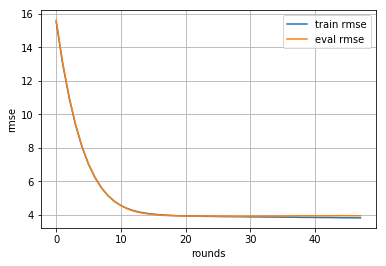

In [72]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

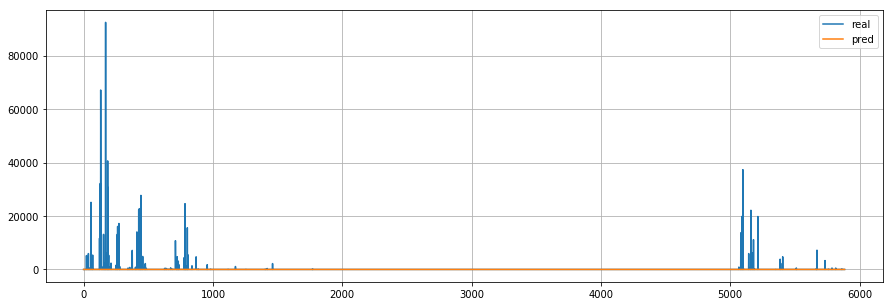

In [73]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['SalesSck'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

In [60]:
from sklearn.metrics import mean_squared_error

mean_squared_error(d_pred, df_val_Y['SalesSck'].values)

4783955.878863293

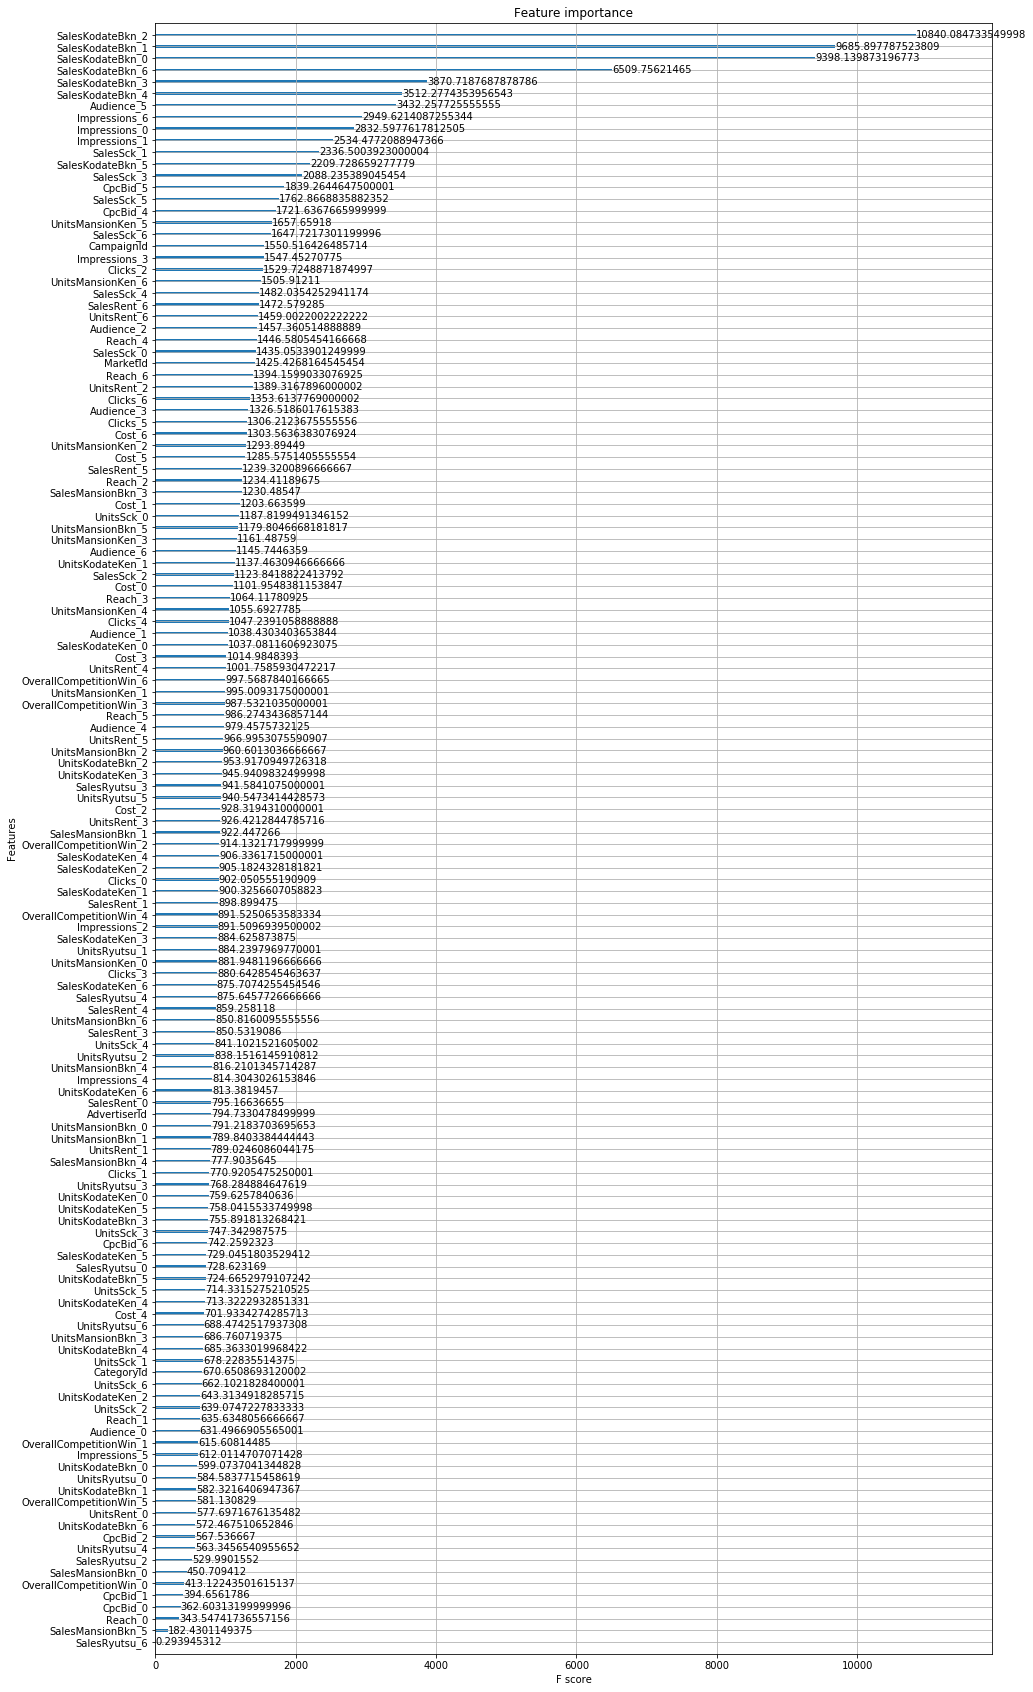

In [63]:
_, ax = plt.subplots(figsize=(15,30))
xgb.plot_importance(model, ax=ax, importance_type='gain')
plt.show()

In [62]:
m = model.get_score(importance_type='gain')
sorted(m, key=lambda x: m[x], reverse=True)

['SalesKodateBkn_2',
 'SalesKodateBkn_1',
 'SalesKodateBkn_0',
 'SalesKodateBkn_6',
 'SalesKodateBkn_3',
 'SalesKodateBkn_4',
 'Audience_5',
 'Impressions_6',
 'Impressions_0',
 'Impressions_1',
 'SalesSck_1',
 'SalesKodateBkn_5',
 'SalesSck_3',
 'CpcBid_5',
 'SalesSck_5',
 'CpcBid_4',
 'UnitsMansionKen_5',
 'SalesSck_6',
 'CampaignId',
 'Impressions_3',
 'Clicks_2',
 'UnitsMansionKen_6',
 'SalesSck_4',
 'SalesRent_6',
 'UnitsRent_6',
 'Audience_2',
 'Reach_4',
 'SalesSck_0',
 'MarketId',
 'Reach_6',
 'UnitsRent_2',
 'Clicks_6',
 'Audience_3',
 'Clicks_5',
 'Cost_6',
 'UnitsMansionKen_2',
 'Cost_5',
 'SalesRent_5',
 'Reach_2',
 'SalesMansionBkn_3',
 'Cost_1',
 'UnitsSck_0',
 'UnitsMansionBkn_5',
 'UnitsMansionKen_3',
 'Audience_6',
 'UnitsKodateKen_1',
 'SalesSck_2',
 'Cost_0',
 'Reach_3',
 'UnitsMansionKen_4',
 'Clicks_4',
 'Audience_1',
 'SalesKodateKen_0',
 'Cost_3',
 'UnitsRent_4',
 'OverallCompetitionWin_6',
 'UnitsMansionKen_1',
 'OverallCompetitionWin_3',
 'Reach_5',
 'Audience_